# By-phone error rates: Buckeye test set
This computes and compares error rates and confusion matrices at the phone level across different models' predicted transcriptions in the Buckeye test set on a reduced symbol set. This helps us understand which phones are most frequently mistaken by the models we're interested in. Conversely, can also see which phones we're performing well on.


In [1]:
import collections
from pathlib import Path
import re

import ipatok
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from phonecodes import phonecodes
import seaborn as sns

from multipa.evaluation import ModelEvaluator, PREDICTION_KEY, EPS, compute_error_rate_confidence_intervals_df
from multipa.evaluation_extras import greedy_reduction_find_and_replace, TIMIT_AND_OTHER_REDUCED_MAPPING, BUCKEYE_REDUCED_MAPPING
from multipa.visualization import plot_error_rates_by_phone_and_model, plot_token_confusion_matrix

/Users/virginia/miniconda3/envs/multipa/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Visualization settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)

# I'm just being picky about plot colors
# This is for "model_group" column
HUE_ORDER = ["Buckeye fine-tuned on full train split", #"full_dataset_train",
             "Buckeye fine-tuned on full gender balanced train set", #"train_duration_20000_samples",
             "excalibur12_wav2vec2-large-lv60_phoneme-timit_english_timit-4k_simplified",
             "openai_whisper-medium.en_to_epitran",
             "facebook_wav2vec2-lv-60-espeak-cv-ft",
             "allosaurus_eng2102_eng",
             "ctaguchi_wav2vec2-large-xlsr-japlmthufielta-ipa1000-ns"
]


HUE_ORDER_INDEX = {key: i for i, key in enumerate(HUE_ORDER)}

font = {"size": 16}
matplotlib.rc("font", **font)

PALETTE = "colorblind"
FONT_SCALE = 1
CONTEXT = "poster"
sns.set_palette(PALETTE)
sns.set_context(context=CONTEXT, font_scale=FONT_SCALE)

VIZ_OUTPUT_DIR = Path("paper_viz")
VIZ_OUTPUT_DIR.mkdir(exist_ok=True)

In [3]:
# Data processing config and functionality
TOKEN_ANALYSIS_OUTPUT = "buckeye_test_token_analysis.csv"
DETAILED_EVAL_PATH = Path("../data/evaluation_results/detailed_predictions/")
POST_PROCESS_OUT_DIR = "by_phone_error_rates_post_proc"
REFERENCE_COL = "ipa"

OUR_BEST_MODEL = "full_dataset_train_5"

# These are the models we're actually interested in evaluating in detail
OUR_EVAL_CSVS = [
    # Models trained on full 20K samples (full dataset but gender balanced)
    "data_models_train_duration_20000_samples_1_wav2vec2-large-xlsr-53-buckeye-ipa_detailed_predictions.csv",
    "data_models_train_duration_20000_samples_2_wav2vec2-large-xlsr-53-buckeye-ipa_detailed_predictions.csv",
    "data_models_train_duration_20000_samples_3_wav2vec2-large-xlsr-53-buckeye-ipa_detailed_predictions.csv",
    "data_models_train_duration_20000_samples_4_wav2vec2-large-xlsr-53-buckeye-ipa_detailed_predictions.csv",
    "data_models_train_duration_20000_samples_5_wav2vec2-large-xlsr-53-buckeye-ipa_detailed_predictions.csv",
    # Models trained on entire dataset
    "ginic_full_dataset_train_1_wav2vec2-large-xlsr-53-buckeye-ipa_detailed_predictions.csv",
    "ginic_full_dataset_train_2_wav2vec2-large-xlsr-53-buckeye-ipa_detailed_predictions.csv",
    "ginic_full_dataset_train_3_wav2vec2-large-xlsr-53-buckeye-ipa_detailed_predictions.csv",
    "ginic_full_dataset_train_4_wav2vec2-large-xlsr-53-buckeye-ipa_detailed_predictions.csv",
    "ginic_full_dataset_train_5_wav2vec2-large-xlsr-53-buckeye-ipa_detailed_predictions.csv",
]

OUR_CSVS_WITH_MAPPING = [(csv, BUCKEYE_REDUCED_MAPPING) for csv in OUR_EVAL_CSVS]

# Third party comparison models - these are the models that performed best on Buckeye from each group
EXTERNAL_EVAL_CSVS = [
    "openai_whisper-medium.en_to_epitran_detailed_predictions.csv",
    "allosaurus_eng2102_eng_detailed_predictions.csv",
    "facebook_wav2vec2-lv-60-espeak-cv-ft_detailed_predictions.csv",
    "ctaguchi_wav2vec2-large-xlsr-japlmthufielta-ipa1000-ns_detailed_predictions.csv",
    "excalibur12_wav2vec2-large-lv60_phoneme-timit_english_timit-4k_simplified_detailed_predictions.csv",
]

EXTERNAL_CSVS_WITH_MAPPING = [(csv, TIMIT_AND_OTHER_REDUCED_MAPPING) for csv in EXTERNAL_EVAL_CSVS]

# Valid Buckeye token set
VALID_BUCKEYE_PHONES = set(phonecodes.phonecode_tables._buckeye2ipa.values())

# Note: This doesn't include all the nasalized vowels, only the ones that we computed the Pillai scores for
# Nasalized vowels shouldn't show up after post-processing, but we'll leave them in so that we
# can make sure they're actually being removed
BUCKEYE_VOWELS = set(["ɑ", "æ", "ʌ", "ɔ", "aʊ", "aɪ", "ɛ", "ɹ̩", "eɪ", "ɪ", "i", "oʊ", "ɔɪ", "ʊ", "u", "æ̃", "ɔ̃",
                  "ə̃", "ĩ", "ẽɪ̃", "õʊ̃", "ãɪ̃", "ɑ̃", "ũ", "ɾ̃", "ə", "ɛ̃", "ʊ̃", "ãʊ̃", "ʌ̃", "ɪ̃", "ɹ̩̃", "ɔ̃ɪ̃"])

BUCKEYE_CONSONANTS = VALID_BUCKEYE_PHONES - BUCKEYE_VOWELS


def diphthong_merge(t1, t2, dipthongs):
    """For merge detected diphthongs in predicted output when using ipatok.tokenise"""
    if t1 + t2 in dipthongs:
        return True
    else:
        return False

# Use for Buckeye tokenization for convenience
buckeye_merge_func = lambda x,y: diphthong_merge(x, y, VALID_BUCKEYE_PHONES)

def get_model_group(model_name):
    if model_name.startswith("train_duration_20000_samples"):
        return "Buckeye fine-tuned on full gender balanced train set"
    elif model_name.startswith("full_dataset_train"):
        return "Buckeye fine-tuned on full train split"
    return model_name


In [4]:
print("TIMIT transform")
for k, v in TIMIT_AND_OTHER_REDUCED_MAPPING.items():
    print(k, [hex(ord(c)) for c in k], ":", v)

TIMIT transform
ɦ ['0x266'] : h
ɨ ['0x268'] : ɪ
ʉ ['0x289'] : u
ɾ̃ ['0x27e', '0x303'] : n
ɝ ['0x25d'] : ɹ̩
ɚ ['0x25a'] : ɹ̩
ʌ ['0x28c'] : ə
ː ['0x2d0'] : 
ũ ['0x75', '0x303'] : u
ə̥ ['0x259', '0x325'] : ə
ɜ˞ ['0x25c', '0x2de'] : ɹ̩


In [5]:
print("Buckeye transform")
for k, v in BUCKEYE_REDUCED_MAPPING.items():
    print(k, [hex(ord(c)) for c in k], ":", v)

Buckeye transform
ãʊ̃ ['0x61', '0x303', '0x28a', '0x303'] : aʊ
ẽɪ̃ ['0x65', '0x303', '0x26a', '0x303'] : eɪ
õʊ̃ ['0x6f', '0x303', '0x28a', '0x303'] : oʊ
ãɪ̃ ['0x61', '0x303', '0x26a', '0x303'] : aɪ
ɔ̃ɪ̃ ['0x254', '0x303', '0x26a', '0x303'] : ɔɪ
æ̃ ['0xe6', '0x303'] : æ
ɔ̃ ['0x254', '0x303'] : ɔ
ə̃ ['0x259', '0x303'] : ə
ĩ ['0x69', '0x303'] : i
ɑ̃ ['0x251', '0x303'] : ɑ
ũ ['0x75', '0x303'] : u
ɛ̃ ['0x25b', '0x303'] : ɛ
ʊ̃ ['0x28a', '0x303'] : ʊ
ɪ̃ ['0x26a', '0x303'] : ɪ
ɹ̩̃ ['0x279', '0x329', '0x303'] : ɹ̩
β ['0x3b2'] : f
ɾ̃ ['0x27e', '0x303'] : n
ʌ̃ ['0x28c', '0x303'] : ə
ʌ ['0x28c'] : ə
õ ['0x6f', '0x303'] : o
õ ['0xf5'] : o
ĩ ['0x129'] : i
ã ['0xe3'] : a
ẽ ['0x65', '0x303'] : e
ẽ ['0x1ebd'] : e
ũ ['0x169'] : u


# Post-process predictions and evaluations
Read in evaluation results, tokenize, and calculate token counts and edit distance errors for each model. 


In [6]:
# Read in model results and re-generate comparison metrics
out_dir = Path(POST_PROCESS_OUT_DIR)
out_dir.mkdir(exist_ok=True)

MODEL_EVALUATOR = ModelEvaluator(tokenise_options={"diphthongs":True, "merge":buckeye_merge_func})

# Will use to make a dataframe that we can pivot to compare model vocabulary by token counts
# in Buckeye test set predictions across models
model_token_counts = []
model_names = []
display_names = []

for (csv, token_mapping) in OUR_CSVS_WITH_MAPPING + EXTERNAL_CSVS_WITH_MAPPING:
    print("Processing", csv)
    if csv.startswith("data_models_train_duration"):
        model_name = re.search(r'train_duration_20000_samples_[1-5]', csv).group()
    elif csv.startswith("ginic_full_dataset_train"):
        model_name = re.search(r'full_dataset_train_[1-5]', csv).group()

    else:
        model_name = csv.removesuffix("_detailed_predictions.csv")
    model_results = pd.read_csv(
            DETAILED_EVAL_PATH / csv,
            dtype={PREDICTION_KEY: str, REFERENCE_COL: str},
            keep_default_na=False
        )
    print("Model name:", model_name)
    model_names.append(model_name)
    # Normalize prediction according to model-specific mapping
    # TODO use IPA tok normalization to clean things up
    model_results[PREDICTION_KEY] = model_results[PREDICTION_KEY].apply(lambda x: greedy_reduction_find_and_replace(x, token_mapping))
    # Normalize reference according to Buckeye reduced symbol set
    latest_ref_col = model_results[REFERENCE_COL].apply(lambda x: greedy_reduction_find_and_replace(x, BUCKEYE_REDUCED_MAPPING))

    MODEL_EVALUATOR.eval_edit_distances(model_name, model_results[PREDICTION_KEY], latest_ref_col, compute_by_token_error_rates=True)
    MODEL_EVALUATOR.write_edit_distance_results(model_name, out_dir)

    model_token_counts.extend([(model_name, t, c) for t,c in MODEL_EVALUATOR._true_token_counts[model_name].items()])

model_token_counts_df = pd.DataFrame(model_token_counts, columns=["model_name", "token", "count"])

Processing data_models_train_duration_20000_samples_1_wav2vec2-large-xlsr-53-buckeye-ipa_detailed_predictions.csv
Model name: train_duration_20000_samples_1
Processing data_models_train_duration_20000_samples_2_wav2vec2-large-xlsr-53-buckeye-ipa_detailed_predictions.csv
Model name: train_duration_20000_samples_2
Processing data_models_train_duration_20000_samples_3_wav2vec2-large-xlsr-53-buckeye-ipa_detailed_predictions.csv
Model name: train_duration_20000_samples_3
Processing data_models_train_duration_20000_samples_4_wav2vec2-large-xlsr-53-buckeye-ipa_detailed_predictions.csv
Model name: train_duration_20000_samples_4
Processing data_models_train_duration_20000_samples_5_wav2vec2-large-xlsr-53-buckeye-ipa_detailed_predictions.csv
Model name: train_duration_20000_samples_5
Processing ginic_full_dataset_train_1_wav2vec2-large-xlsr-53-buckeye-ipa_detailed_predictions.csv
Model name: full_dataset_train_1
Processing ginic_full_dataset_train_2_wav2vec2-large-xlsr-53-buckeye-ipa_detailed_pr

In [7]:
display(model_token_counts_df.head())

,model_name,token,count
0,train_duration_20000_samples_1,f,2363
1,train_duration_20000_samples_1,ɔ,1725
2,train_duration_20000_samples_1,ɹ,6185
3,train_duration_20000_samples_1,aɪ,4216
4,train_duration_20000_samples_1,v,2329


In [8]:
# Sanity check token counts in the gold-standard labels against actual vocabulary
# The invalid token warnings are harmless, it's just removing some "NOISE" and disfluency markers that snuck through
# data preprocessing, but don't affect training because they aren't in the model vocab
final_token_counts = {t:0 for t in VALID_BUCKEYE_PHONES}

tokens = []
for ref in latest_ref_col:
    tokens.extend(ipatok.tokenise(ref, diphthongs=True, merge = buckeye_merge_func))

test_token_counts = collections.Counter(tokens)
final_token_counts.update(test_token_counts)

for t in list(final_token_counts.keys()):
    if t not in VALID_BUCKEYE_PHONES:
        print("REMOVING INVALID TOKEN:", t, t.encode("unicode-escape"))
        del final_token_counts[t]

token_counts_df = pd.DataFrame.from_records(
        list(final_token_counts.items()),
        columns=["phone", "counts"]).sort_values("counts", ascending=False)

print("Full inventory token counts")
display(token_counts_df)

token_counts_df = token_counts_df[token_counts_df["counts"] > 0]
print("Inventory for analysis token counts")
display(token_counts_df)


REMOVING INVALID TOKEN: O b'O'
REMOVING INVALID TOKEN: I b'I'
REMOVING INVALID TOKEN: E b'E'
REMOVING INVALID TOKEN: A b'A'
REMOVING INVALID TOKEN: U b'U'
REMOVING INVALID TOKEN: H b'H'
Full inventory token counts


,phone,counts
46,ə,14566
15,ɪ,12506
11,n,11579
55,s,8389
60,ɛ,6901
26,i,6659
51,t,6465
20,ɹ,6185
59,k,5349
62,l,5348


Inventory for analysis token counts


,phone,counts
46,ə,14566
15,ɪ,12506
11,n,11579
55,s,8389
60,ɛ,6901
26,i,6659
51,t,6465
20,ɹ,6185
59,k,5349
62,l,5348


In [9]:
# Munge by phone errors into a single dataframe
records = []
for model_name, eval_results in MODEL_EVALUATOR.results_to_write.items():
    for phone, err_rate in eval_results[MODEL_EVALUATOR.by_token_error_rates].items():
        if phone in VALID_BUCKEYE_PHONES:
            records.append((model_name, phone, err_rate))

all_error_rates_df = pd.DataFrame.from_records(records, columns=["model_name", "phone", "err_rate"])
all_error_rates_df["model_group"] = all_error_rates_df["model_name"].apply(get_model_group)

all_error_rates_df = compute_error_rate_confidence_intervals_df(all_error_rates_df,token_counts_df, "phone", "phone", "err_rate", "counts")

In [10]:
display(all_error_rates_df.head())

,model_name,phone,err_rate,model_group,counts,confidence_interval
0,train_duration_20000_samples_1,f,0.089716,Buckeye fine-tuned on full gender balanced train set,2363,0.011523
1,train_duration_20000_samples_2,f,0.121879,Buckeye fine-tuned on full gender balanced train set,2363,0.013191
2,train_duration_20000_samples_3,f,0.084215,Buckeye fine-tuned on full gender balanced train set,2363,0.011197
3,train_duration_20000_samples_4,f,0.081676,Buckeye fine-tuned on full gender balanced train set,2363,0.011043
4,train_duration_20000_samples_5,f,0.092679,Buckeye fine-tuned on full gender balanced train set,2363,0.011692


# By-token error rates
Display each model's error rates for each token.

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


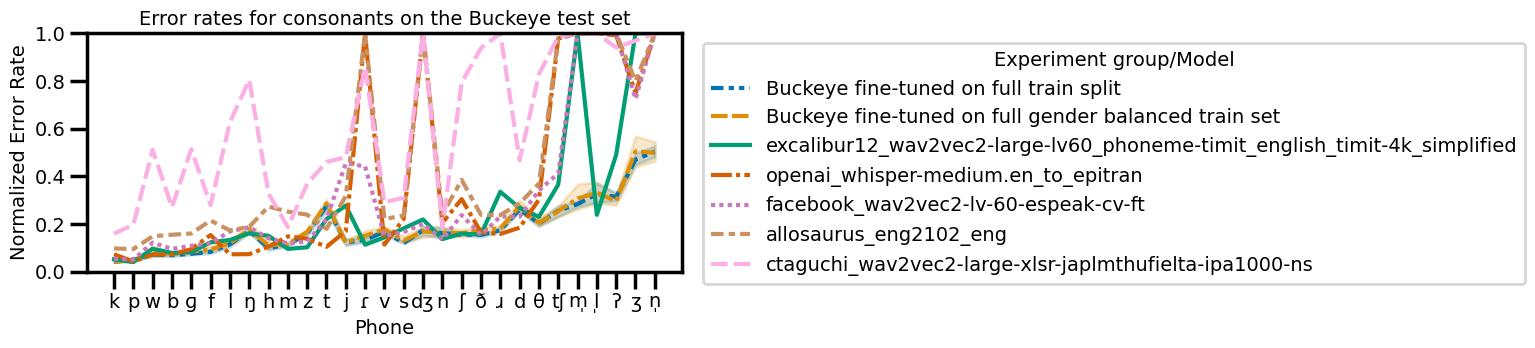

In [11]:
consonant_df = all_error_rates_df[all_error_rates_df["phone"].isin(BUCKEYE_CONSONANTS)]
plot_error_rates_by_phone_and_model(consonant_df, "model_group", hue_order=HUE_ORDER, palette=PALETTE, title="Error rates for consonants on the Buckeye test set", figsize=(16, 4))
plt.tight_layout()
plt.savefig(VIZ_OUTPUT_DIR / "buckeye_consonant_error_rates_all_models.eps", format="eps")

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


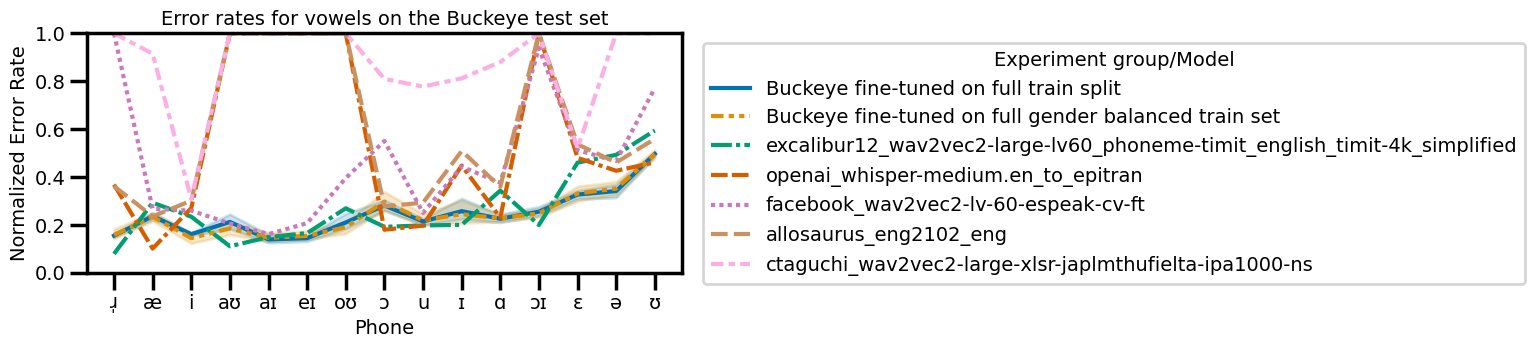

In [12]:
vowel_df = all_error_rates_df[all_error_rates_df["phone"].isin(BUCKEYE_VOWELS)]
plot_error_rates_by_phone_and_model(vowel_df, "model_group", hue_order=HUE_ORDER, palette=PALETTE, title="Error rates for vowels on the Buckeye test set", figsize=(16, 4))
plt.tight_layout()
plt.savefig(VIZ_OUTPUT_DIR / "buckeye_vowel_error_rates_all_models.eps", format="eps")

In [13]:
our_models = all_error_rates_df[all_error_rates_df["model_group"].isin(["Buckeye fine-tuned on full train split",
             "Buckeye fine-tuned on full gender balanced train set"])]
our_models["display_name"] = our_models["model_name"].apply(lambda x: get_model_group(x) + " " + x[-1:])
model_orders = [f"Buckeye fine-tuned on full train split {i}" for i in range(1, 6)] + [f"Buckeye fine-tuned on full gender balanced train set {i}" for i in range(1, 6)]
display(our_models.head())

/var/folders/7c/4fzv15450s1bt_03bv1b6hb80000gn/T/ipykernel_33062/2803480292.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  our_models["display_name"] = our_models["model_name"].apply(lambda x: get_model_group(x) + " " + x[-1:])


,model_name,phone,err_rate,model_group,counts,confidence_interval,display_name
0,train_duration_20000_samples_1,f,0.089716,Buckeye fine-tuned on full gender balanced train set,2363,0.011523,Buckeye fine-tuned on full gender balanced train set 1
1,train_duration_20000_samples_2,f,0.121879,Buckeye fine-tuned on full gender balanced train set,2363,0.013191,Buckeye fine-tuned on full gender balanced train set 2
2,train_duration_20000_samples_3,f,0.084215,Buckeye fine-tuned on full gender balanced train set,2363,0.011197,Buckeye fine-tuned on full gender balanced train set 3
3,train_duration_20000_samples_4,f,0.081676,Buckeye fine-tuned on full gender balanced train set,2363,0.011043,Buckeye fine-tuned on full gender balanced train set 4
4,train_duration_20000_samples_5,f,0.092679,Buckeye fine-tuned on full gender balanced train set,2363,0.011692,Buckeye fine-tuned on full gender balanced train set 5


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


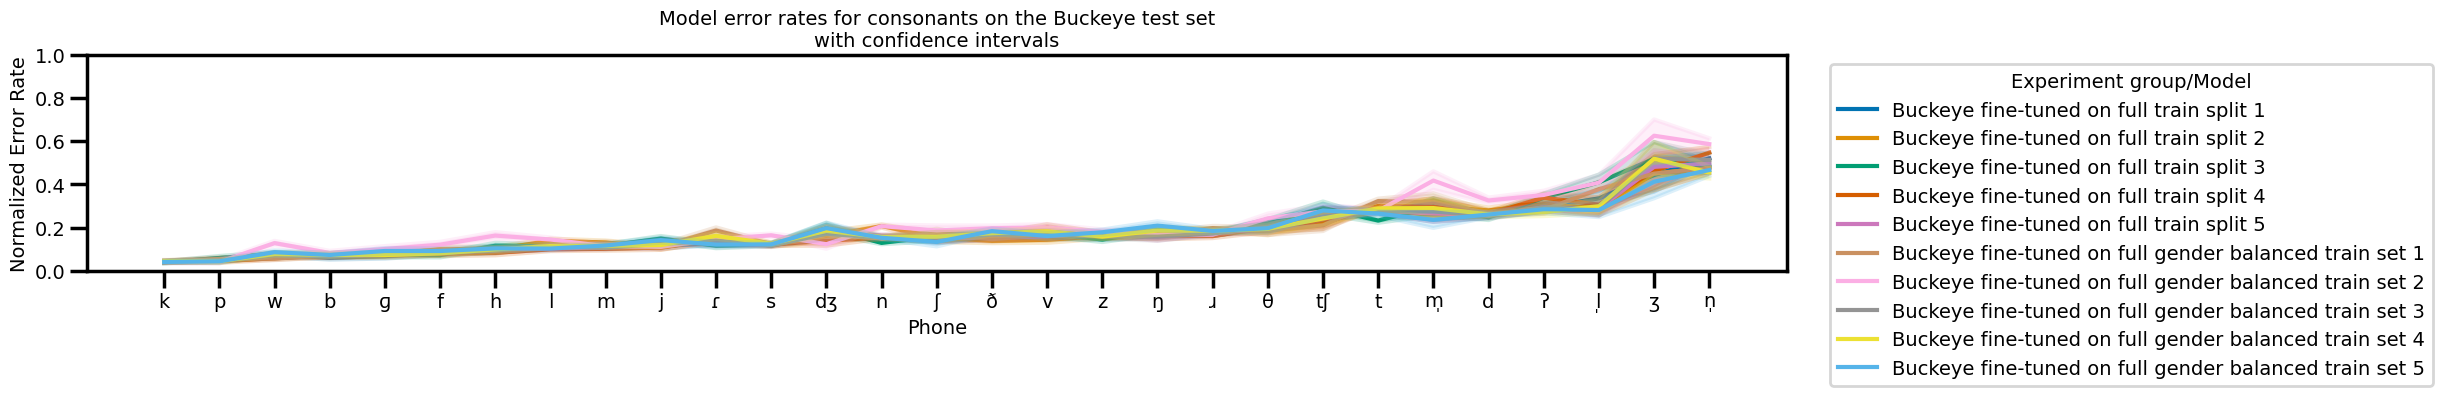

In [14]:
our_models_consonants = our_models[our_models["phone"].isin(BUCKEYE_CONSONANTS)]
plot_error_rates_by_phone_and_model(our_models_consonants, "display_name", hue_order = model_orders, palette=PALETTE, title="Model error rates for consonants on the Buckeye test set\nwith confidence intervals", use_confidence_intervals=True)
plt.tight_layout()
plt.savefig(VIZ_OUTPUT_DIR / "buckeye_consonants_errors_with_confidence_intervals.eps", format="eps")

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


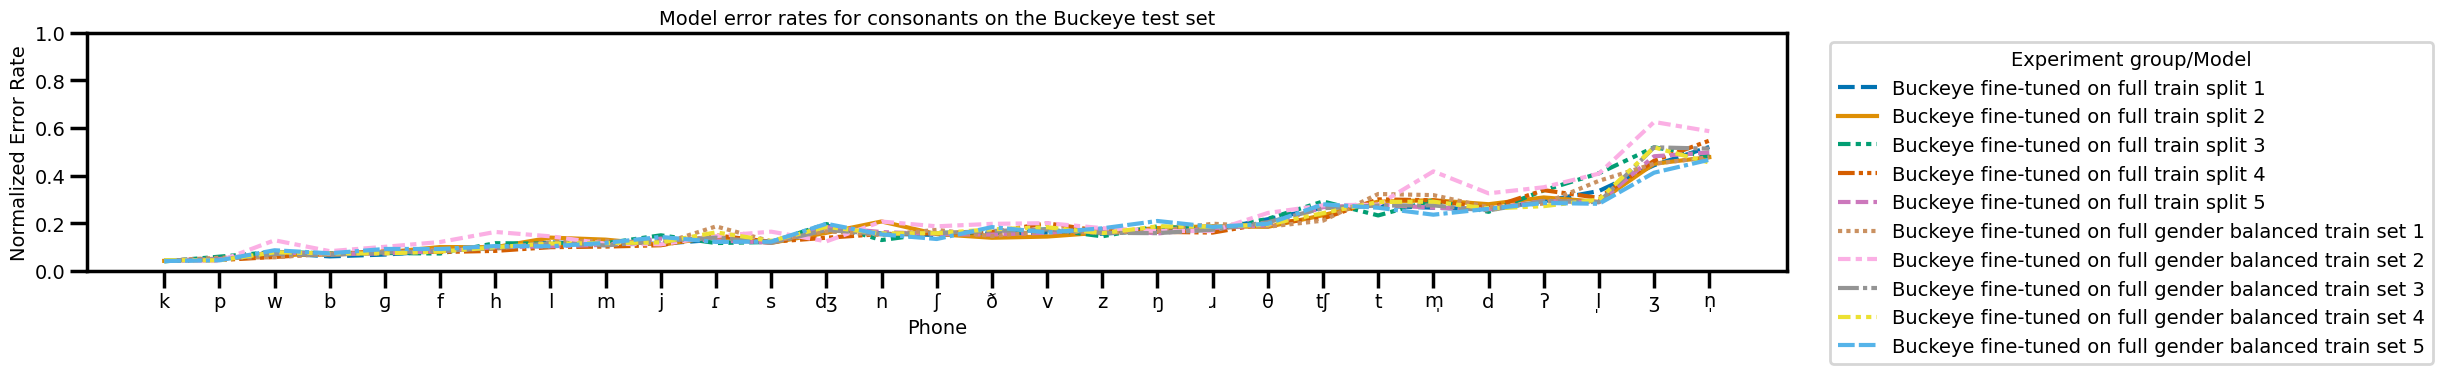

In [15]:
plot_error_rates_by_phone_and_model(our_models_consonants, "display_name", hue_order = model_orders, palette=PALETTE, title="Model error rates for consonants on the Buckeye test set")
plt.tight_layout()
plt.savefig(VIZ_OUTPUT_DIR / "buckeye_consonants_error_rates.eps", format="eps")

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


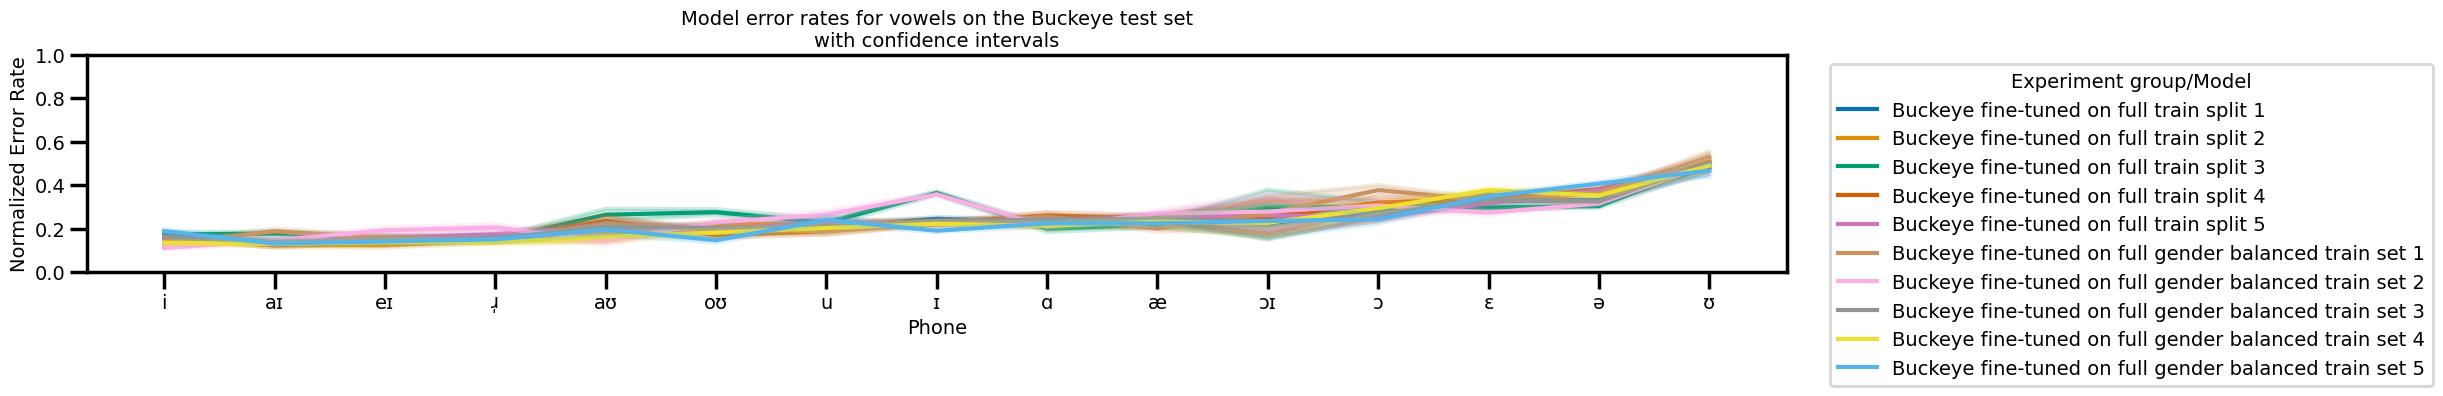

In [16]:
our_models_vowels = our_models[our_models["phone"].isin(BUCKEYE_VOWELS)]
plot_error_rates_by_phone_and_model(our_models_vowels, "display_name", hue_order = model_orders, palette=PALETTE, title="Model error rates for vowels on the Buckeye test set\nwith confidence intervals", use_confidence_intervals=True, )
plt.tight_layout()
plt.savefig(VIZ_OUTPUT_DIR / "buckeye_vowel_errors_with_confidence_intervals.eps", format="eps")

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


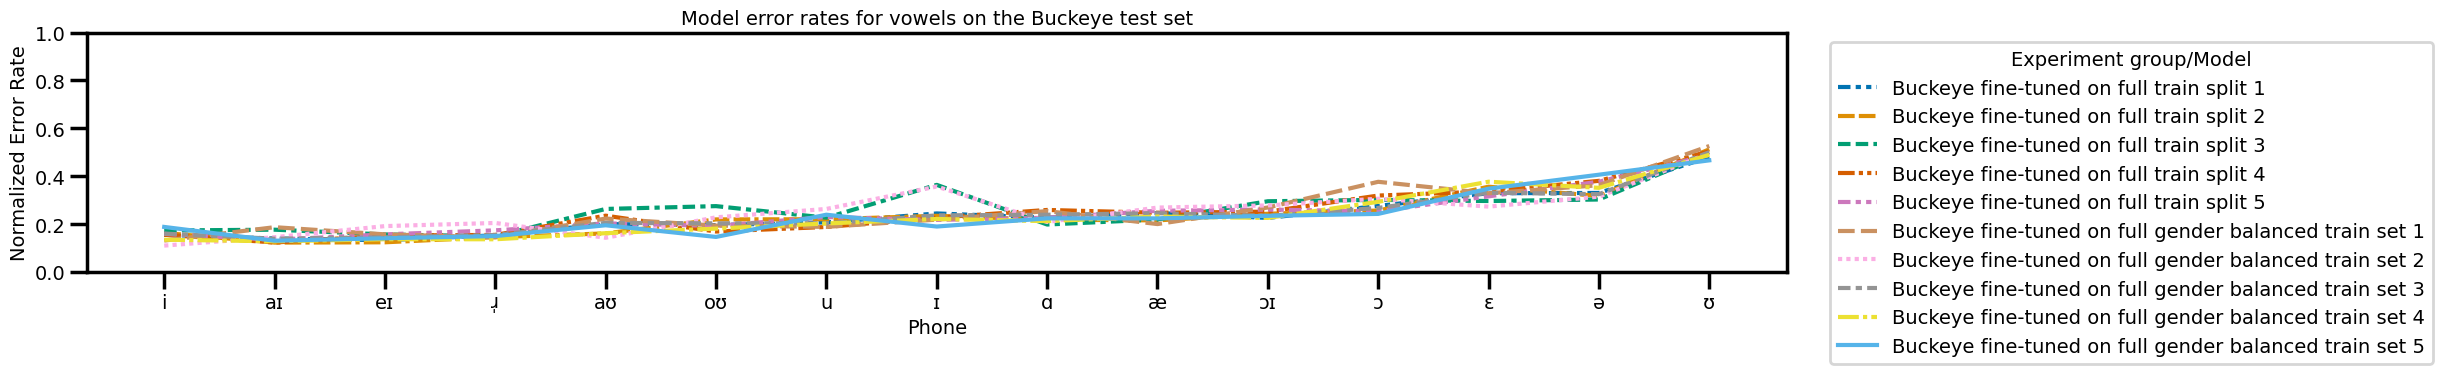

In [17]:
plot_error_rates_by_phone_and_model(our_models_vowels, "display_name", palette=PALETTE, title="Model error rates for vowels on the Buckeye test set", hue_order = model_orders)
plt.tight_layout()
plt.savefig(VIZ_OUTPUT_DIR / "buckeye_vowel_error_rates.eps", format="eps")

<Axes: title={'center': 'Error rates for consonants on the Buckeye test\naveraged across experiment groups'}, xlabel='Phone', ylabel='Normalized Error Rate'>

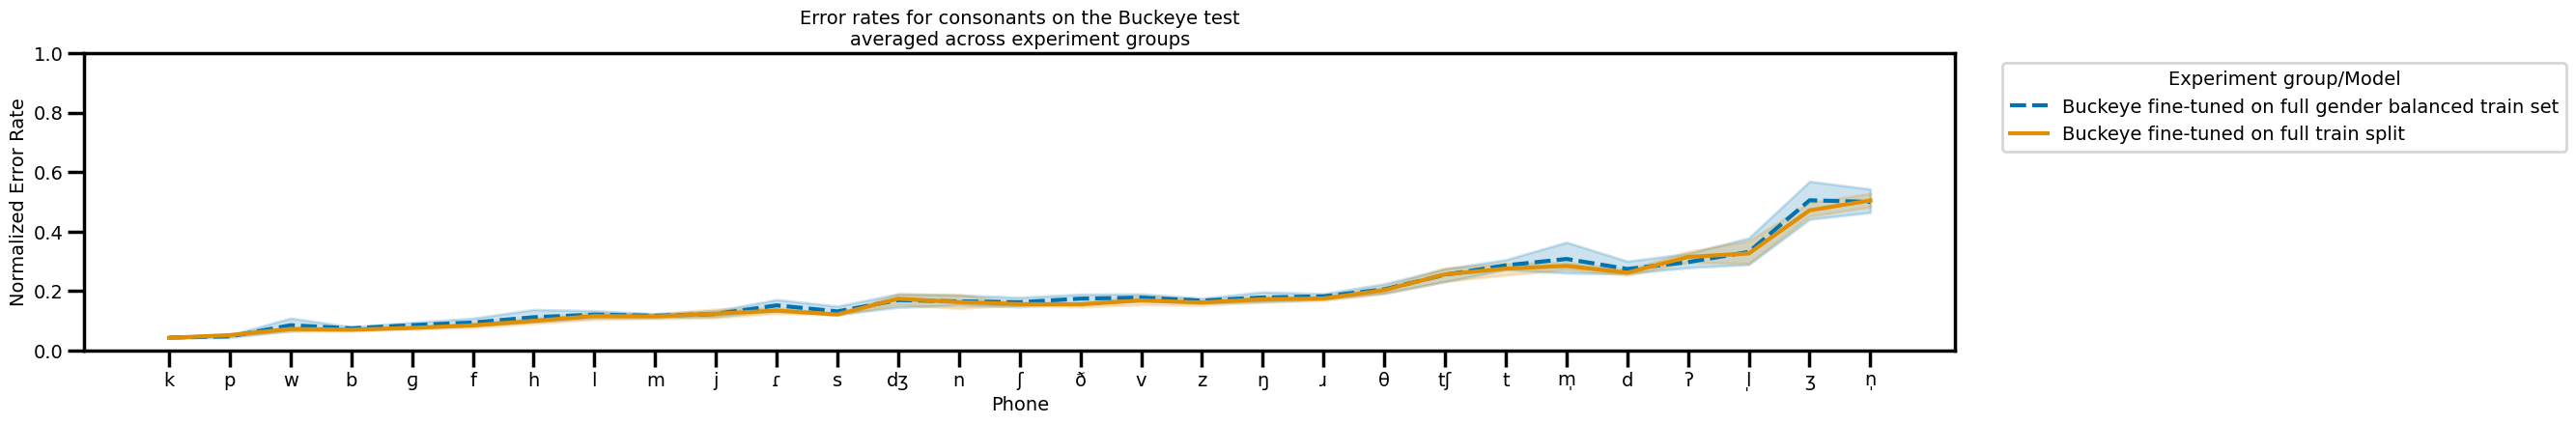

In [18]:
plot_error_rates_by_phone_and_model(our_models_consonants, "model_group", palette=PALETTE, title="Error rates for consonants on the Buckeye test\naveraged across experiment groups",)

<Axes: title={'center': 'Error rates for vowels on the Buckeye test\naveraged across experiment groups'}, xlabel='Phone', ylabel='Normalized Error Rate'>

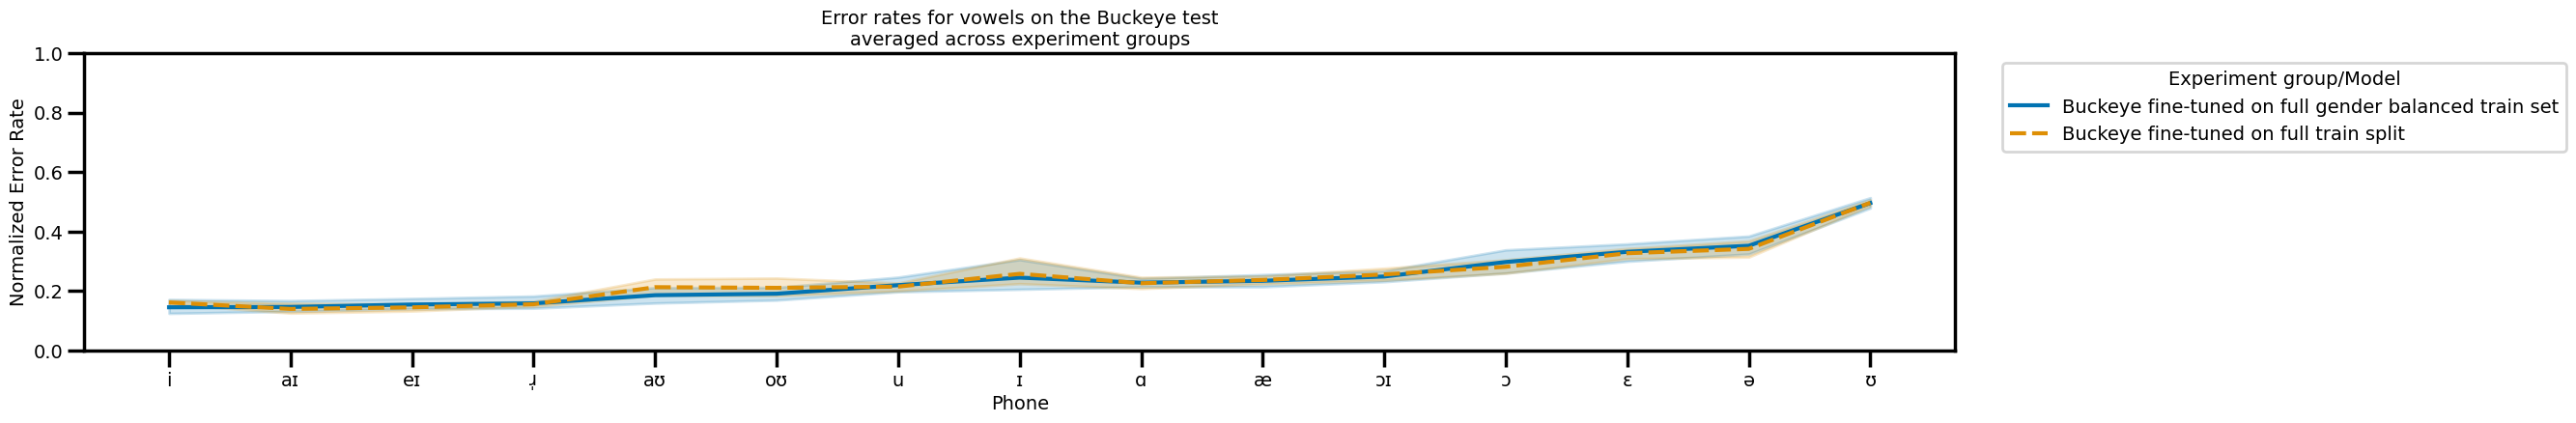

In [19]:
plot_error_rates_by_phone_and_model(our_models_vowels, "model_group", palette=PALETTE, title="Error rates for vowels on the Buckeye test\naveraged across experiment groups",)

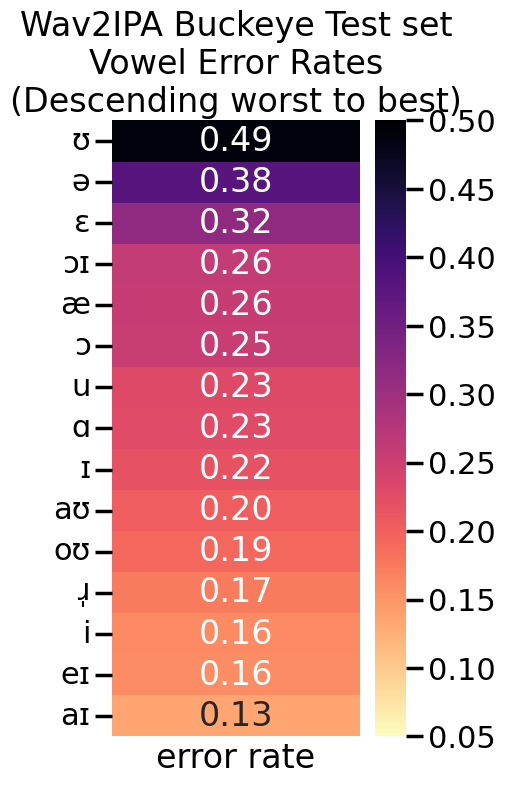

<Figure size 640x480 with 0 Axes>

In [20]:
vowel_df = all_error_rates_df[(all_error_rates_df["phone"].isin(BUCKEYE_VOWELS)) & (all_error_rates_df["model_name"] == OUR_BEST_MODEL)][["phone", "err_rate"]]
tmp_df = vowel_df.sort_values(by="err_rate", ascending=False).set_index("phone")
plt.figure(figsize=(4, 8))
sns.heatmap(
    tmp_df,
    cmap="magma_r",
    # cmap="spring_r",
    annot=True,
    fmt=".2f",
    yticklabels=True,
    xticklabels=False,
    # linewidths=1,
    vmin=0.05,
    vmax=0.5
)
plt.title("Wav2IPA Buckeye Test set\nVowel Error Rates\n(Descending worst to best)")
# plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.ylabel("")
plt.xlabel("error rate")
plt.show()
plt.tight_layout()
plt.savefig(VIZ_OUTPUT_DIR / "buckeye_ver_heatmap.eps", format="eps")


In [21]:
# Check top 5 most common mistakes for each vowel
interesting_vowels = vowel_df[vowel_df["err_rate"] > 0.0]["phone"].tolist()

# Sanity check there's no duplicates
assert len(interesting_vowels) == len(set(interesting_vowels))

model_results_to_include = MODEL_EVALUATOR.results_to_write[OUR_BEST_MODEL]

interesting_errors = []
for v in interesting_vowels:
    for ((x, y), c) in model_results_to_include["substitutions"].items():
        if x == v:
            interesting_errors.append((v, y, c))

    dels = model_results_to_include["deletions"][v]
    interesting_errors.append((v, "***", dels))


interesting_errors_df = pd.DataFrame(interesting_errors, columns=["Vowel", "Error", "Count"])
interesting_errors_df["Ratio of Vowel's Errors"] = interesting_errors_df.groupby("Vowel", group_keys=False)["Count"].apply(lambda x: x / x.sum())
display(interesting_errors_df.head())


,Vowel,Error,Count,Ratio of Vowel's Errors
0,ɔ,ɑ,82,0.187215
1,ɔ,s,1,0.002283
2,ɔ,ə,64,0.146119
3,ɔ,oʊ,117,0.267123
4,ɔ,ɪ,20,0.045662


In [22]:
top_errors_df = interesting_errors_df.groupby("Vowel").apply(lambda x: x.nlargest(5, "Count")).reset_index(drop=True)
top_errors_df["Vowel"] = pd.Categorical(top_errors_df["Vowel"], ordered=True)
top_errors_df = top_errors_df.sort_values(by=["Vowel", "Count"], ascending=[True, False])
display(top_errors_df.head(10))

,Vowel,Error,Count,Ratio of Vowel's Errors
0,aɪ,***,136,0.239016
1,aɪ,ə,126,0.221441
2,aɪ,ɑ,110,0.193322
3,aɪ,ɛ,62,0.108963
4,aɪ,æ,48,0.084359
5,aʊ,ɑ,82,0.403941
6,aʊ,æ,29,0.142857
7,aʊ,***,27,0.133005
8,aʊ,ə,20,0.098522
9,aʊ,oʊ,14,0.068966


<Figure size 1600x1600 with 0 Axes>

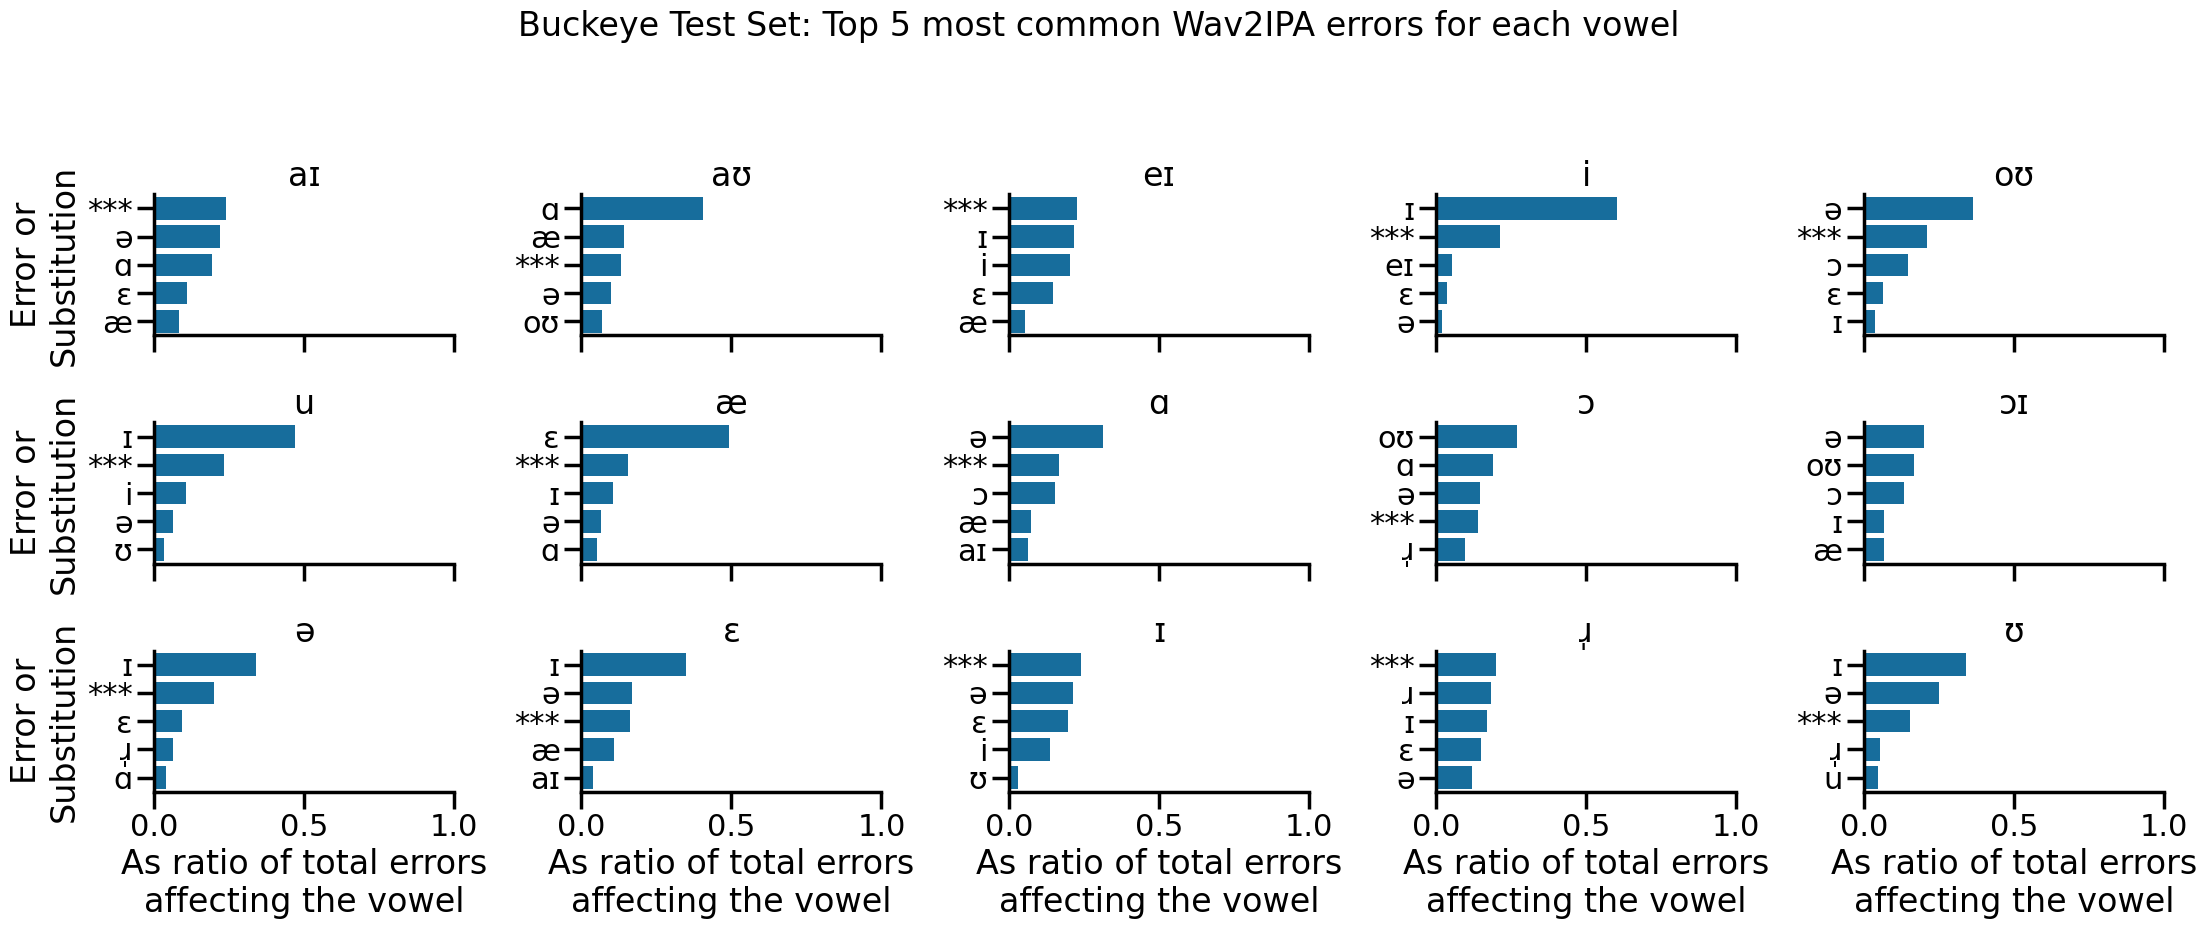

In [23]:
plt.figure(figsize=(16, 16))
g = sns.FacetGrid(top_errors_df, col="Vowel", col_wrap=5, sharey=False, aspect=1.5, xlim=(0, 1))
g.map_dataframe(sns.barplot, x="Ratio of Vowel's Errors", y="Error", orient="h")
g.set_titles(col_template="{col_name}", fontsize=20)
g.set_ylabels("Error or\nSubstitution")
g.set_xlabels("As ratio of total errors\naffecting the vowel")
g.fig.suptitle("Buckeye Test Set: Top 5 most common Wav2IPA errors for each vowel", fontsize=24, y=1.05)
plt.tight_layout()
plt.savefig(VIZ_OUTPUT_DIR / "buckeye_most_common_vowel_errors.eps", format="eps")

# Confusion matrices
Get the confusion matrix for each model's errors. Display confusion matrix separated by consonants and vowels separately for a few select models. 

In [24]:
# Gets the confusion matrix for each model
conf_matrices = {}
for mn in model_names:
    print("Model name:", mn)
    conf_matrices[mn] = MODEL_EVALUATOR.get_token_confusion_matrix(mn)


Model name: train_duration_20000_samples_1
Model name: train_duration_20000_samples_2
Model name: train_duration_20000_samples_3
Model name: train_duration_20000_samples_4
Model name: train_duration_20000_samples_5
Model name: full_dataset_train_1
Model name: full_dataset_train_2
Model name: full_dataset_train_3
Model name: full_dataset_train_4
Model name: full_dataset_train_5
Model name: openai_whisper-medium.en_to_epitran
Model name: allosaurus_eng2102_eng
Model name: facebook_wav2vec2-lv-60-espeak-cv-ft
Model name: ctaguchi_wav2vec2-large-xlsr-japlmthufielta-ipa1000-ns
Model name: excalibur12_wav2vec2-large-lv60_phoneme-timit_english_timit-4k_simplified


<Figure size 640x480 with 0 Axes>

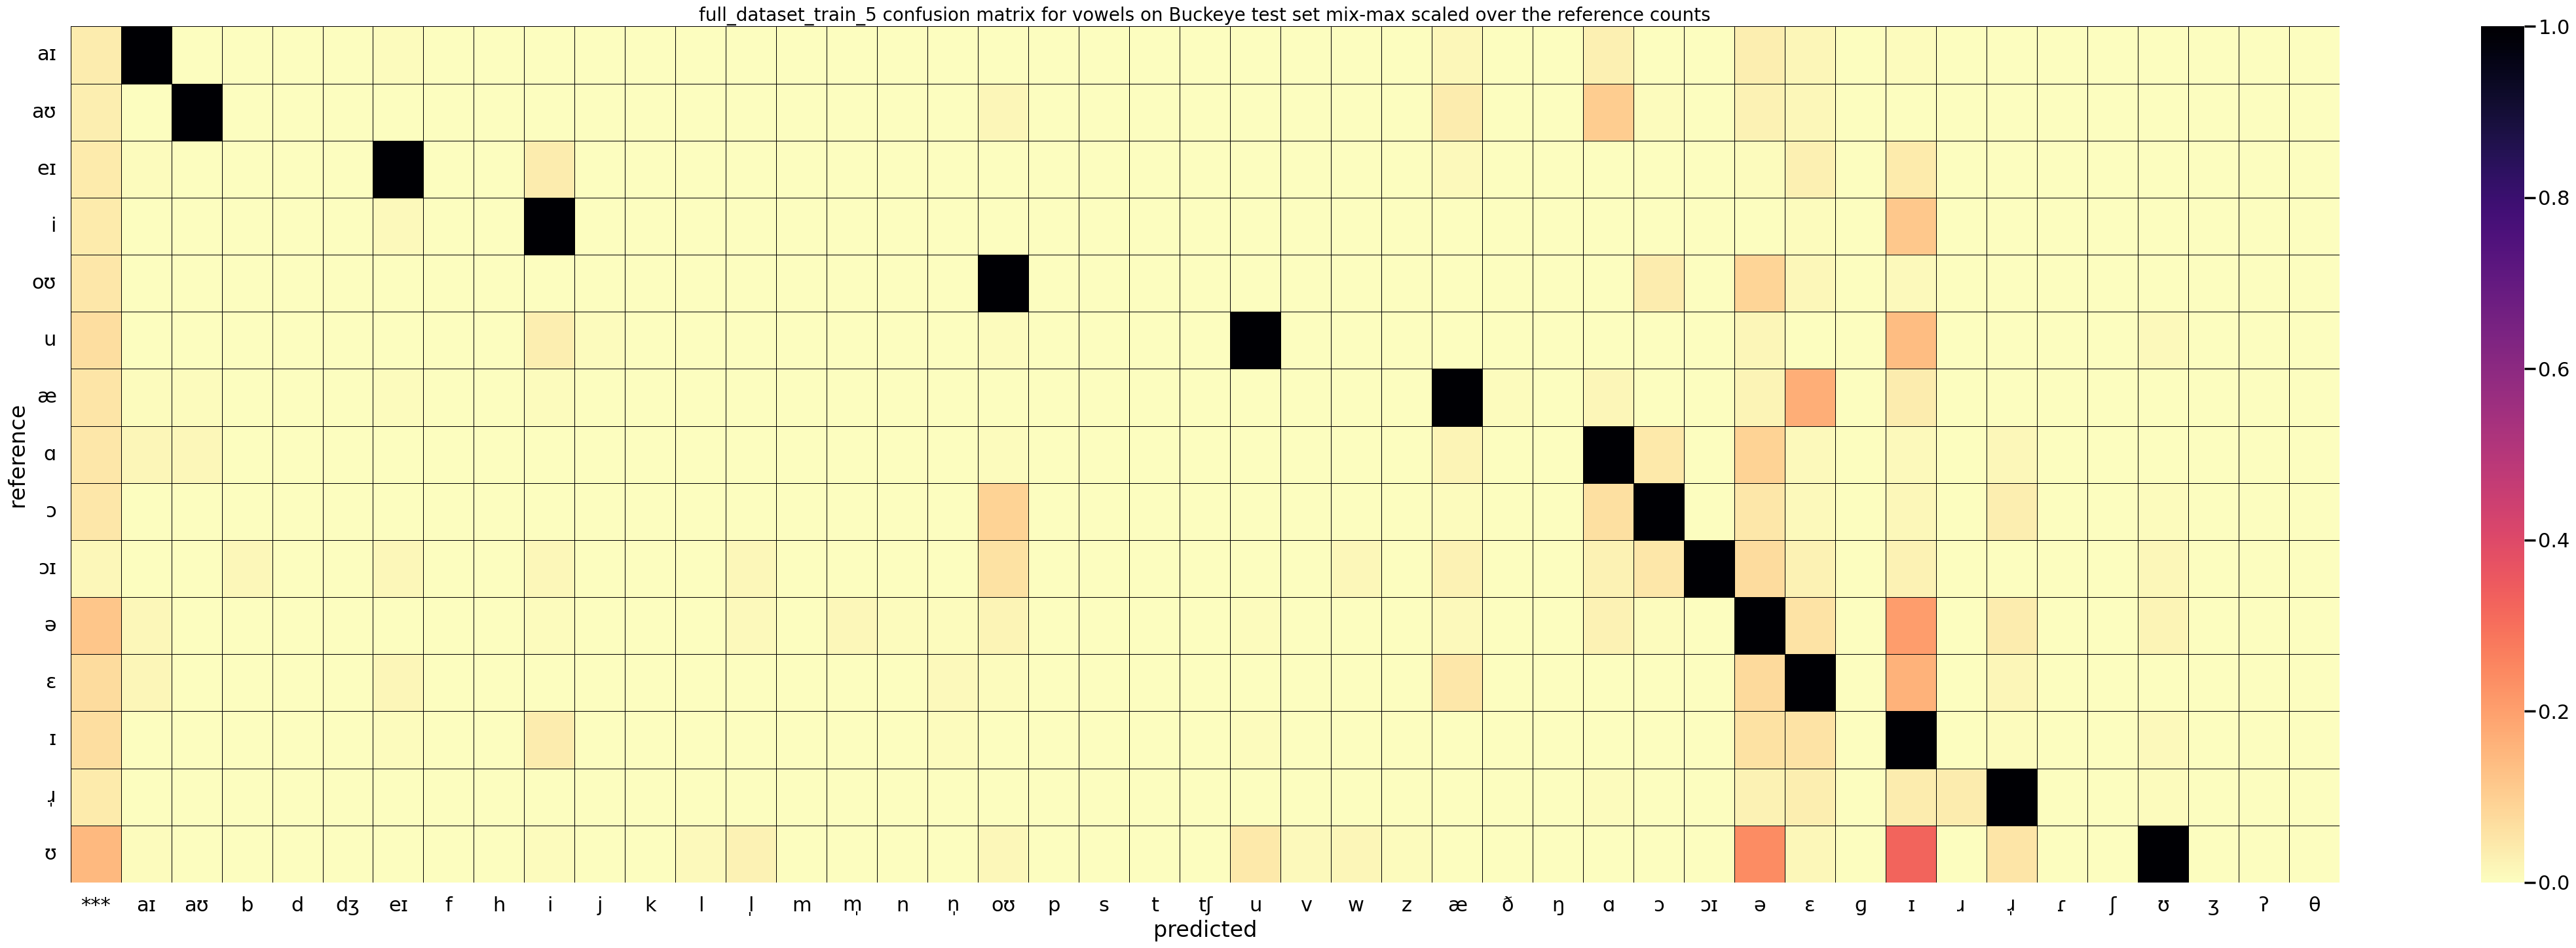

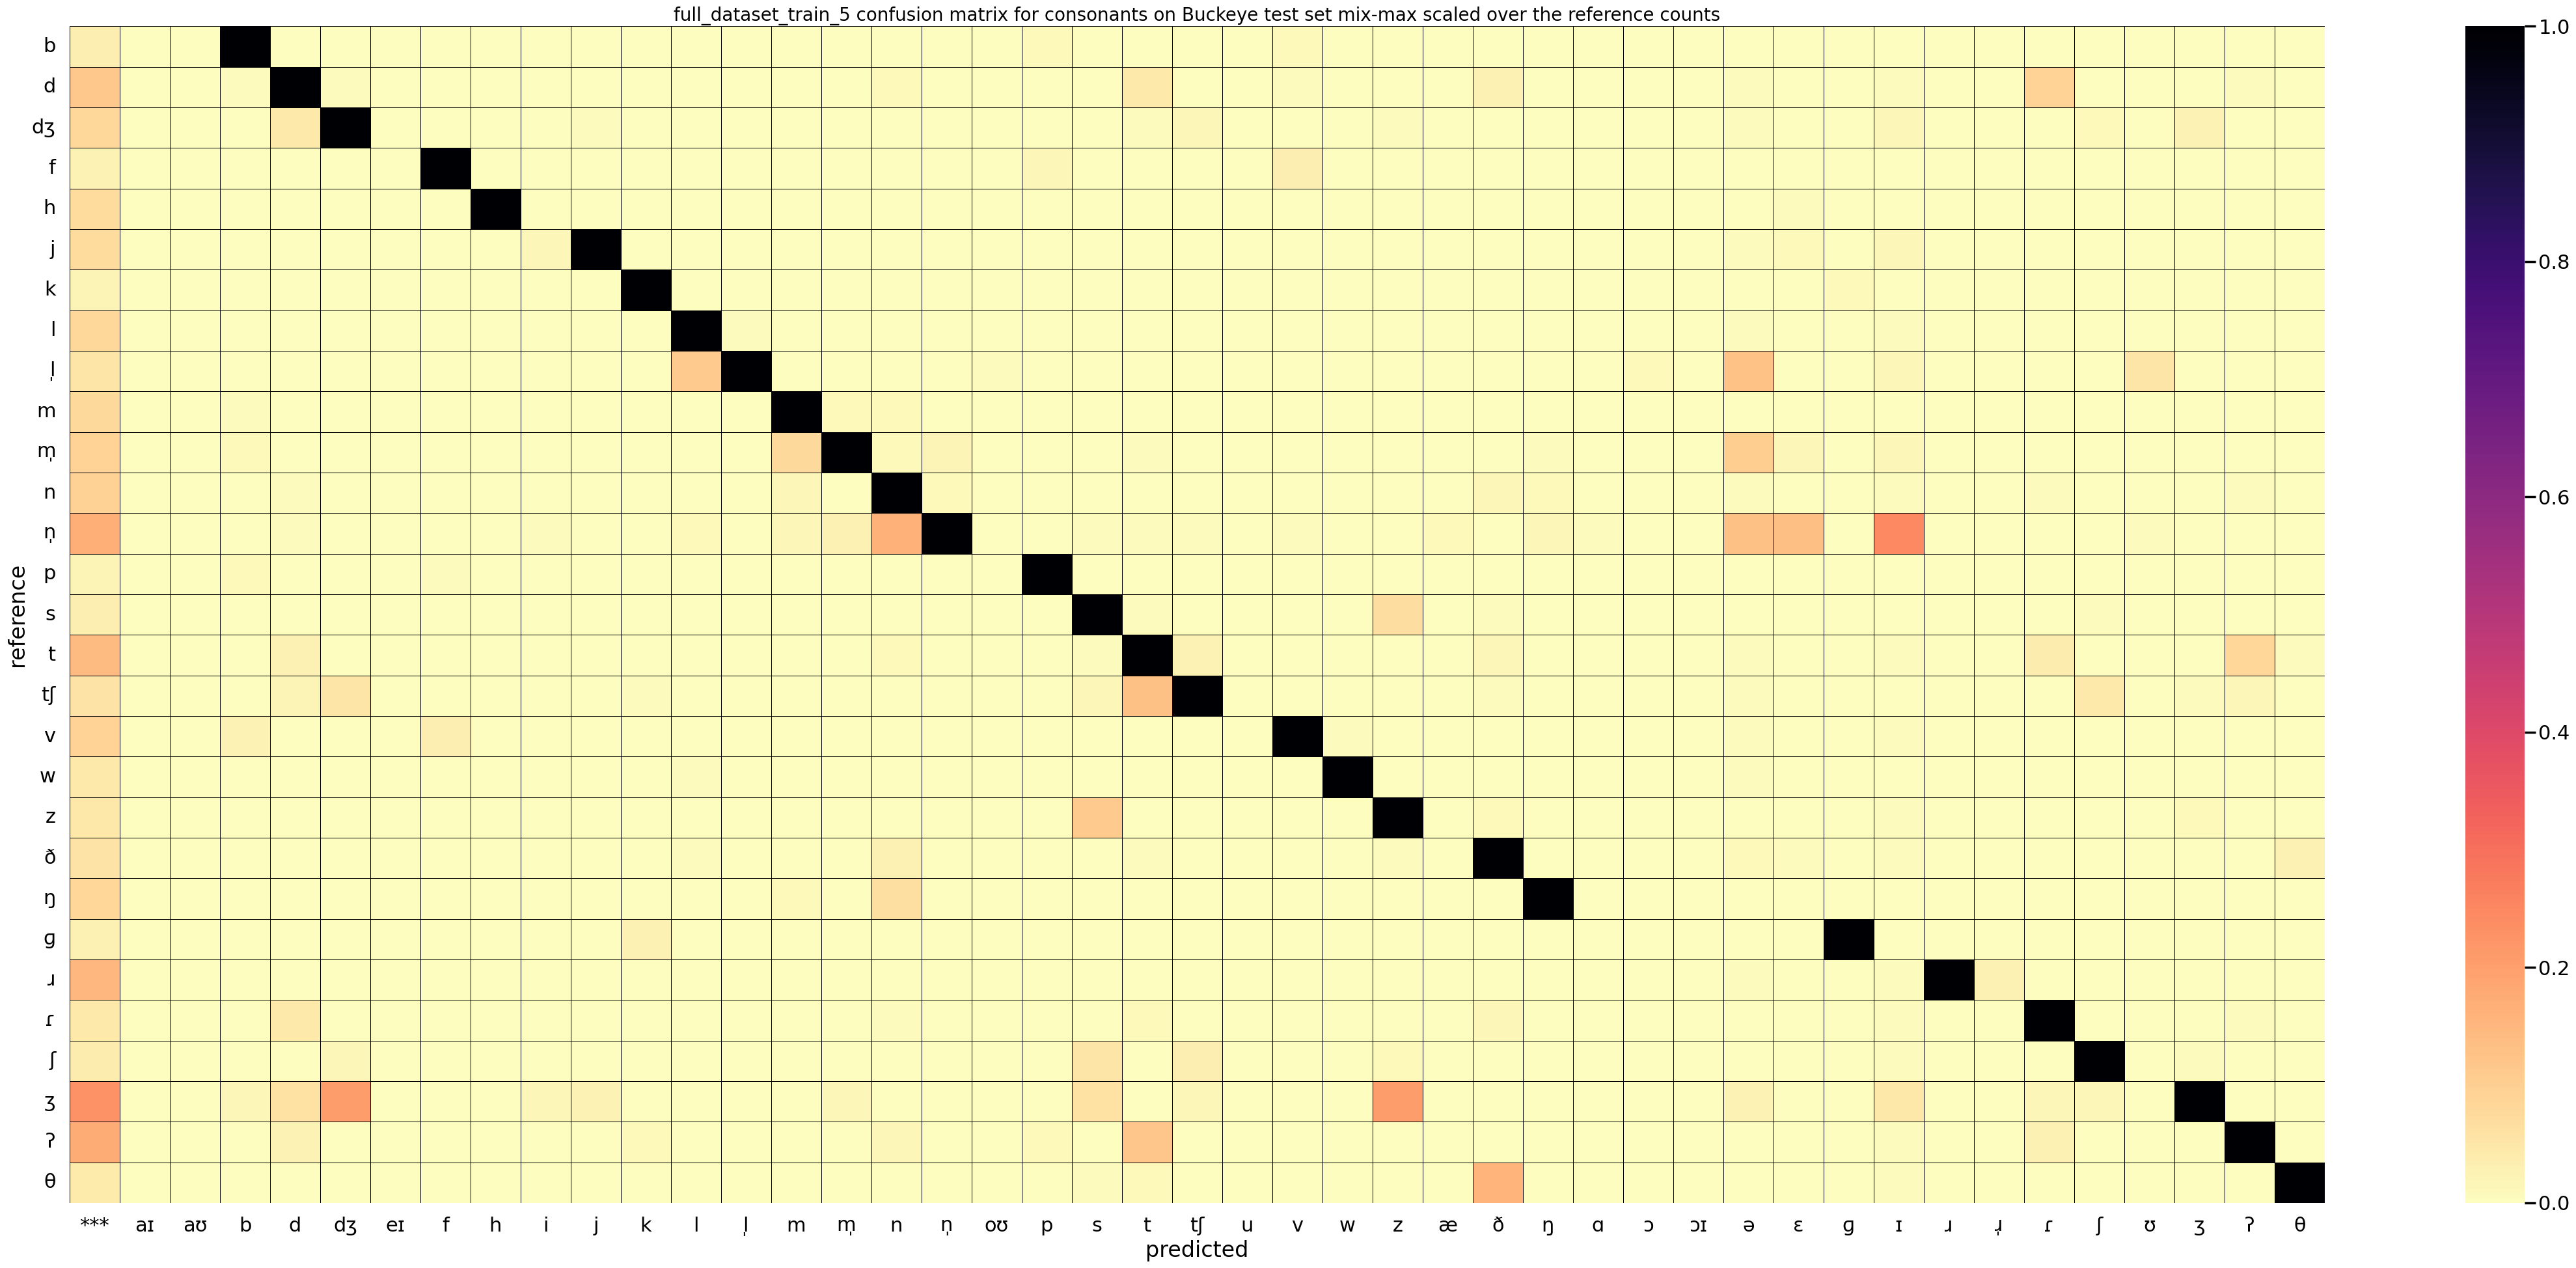

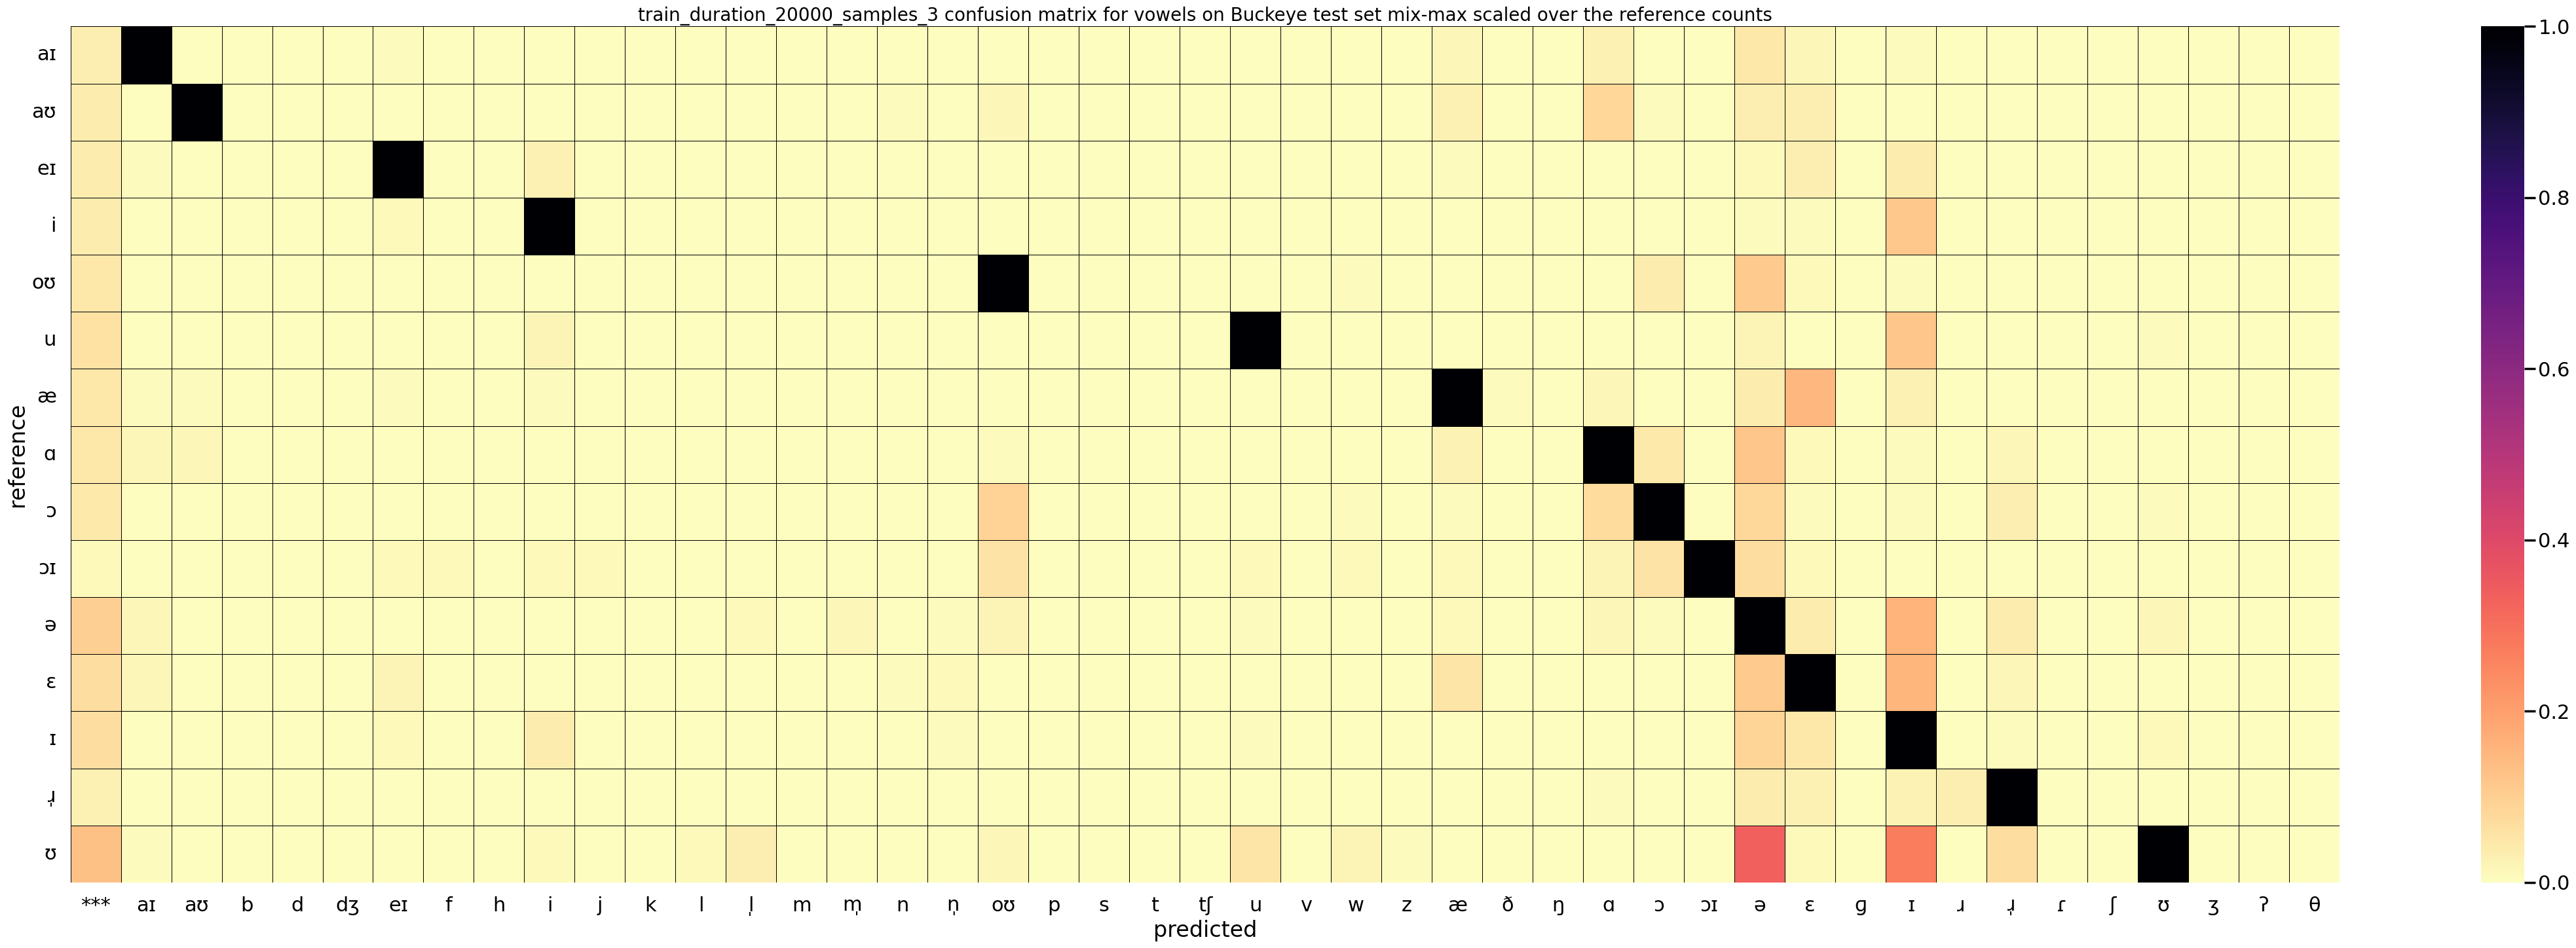

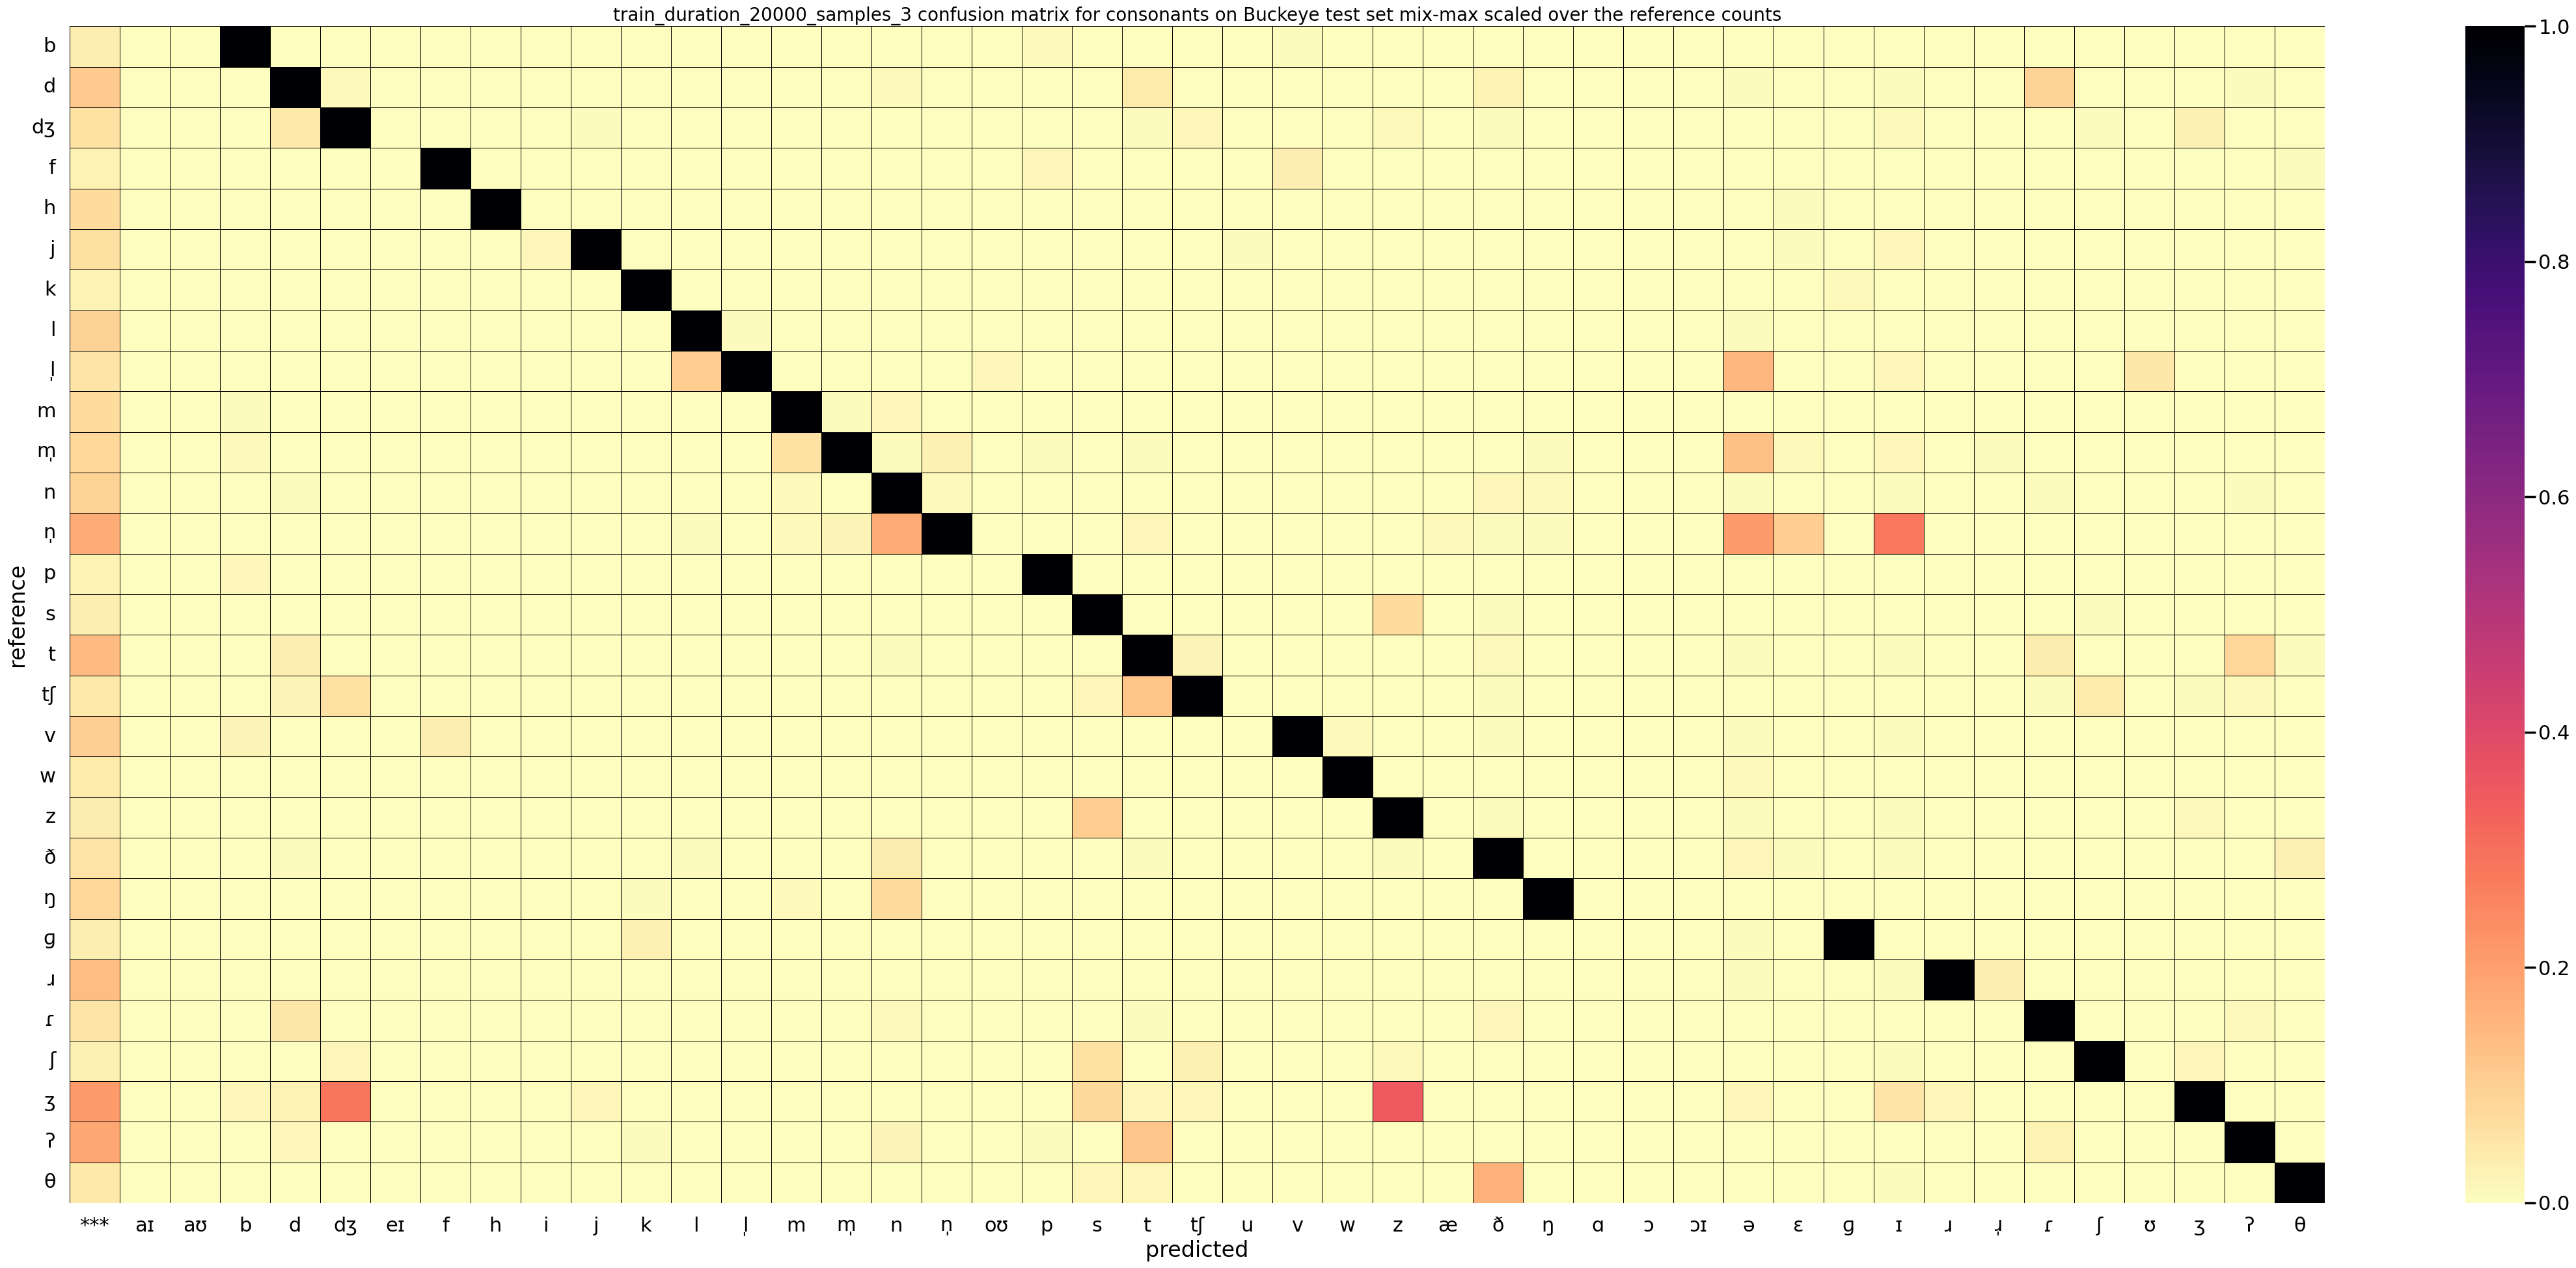

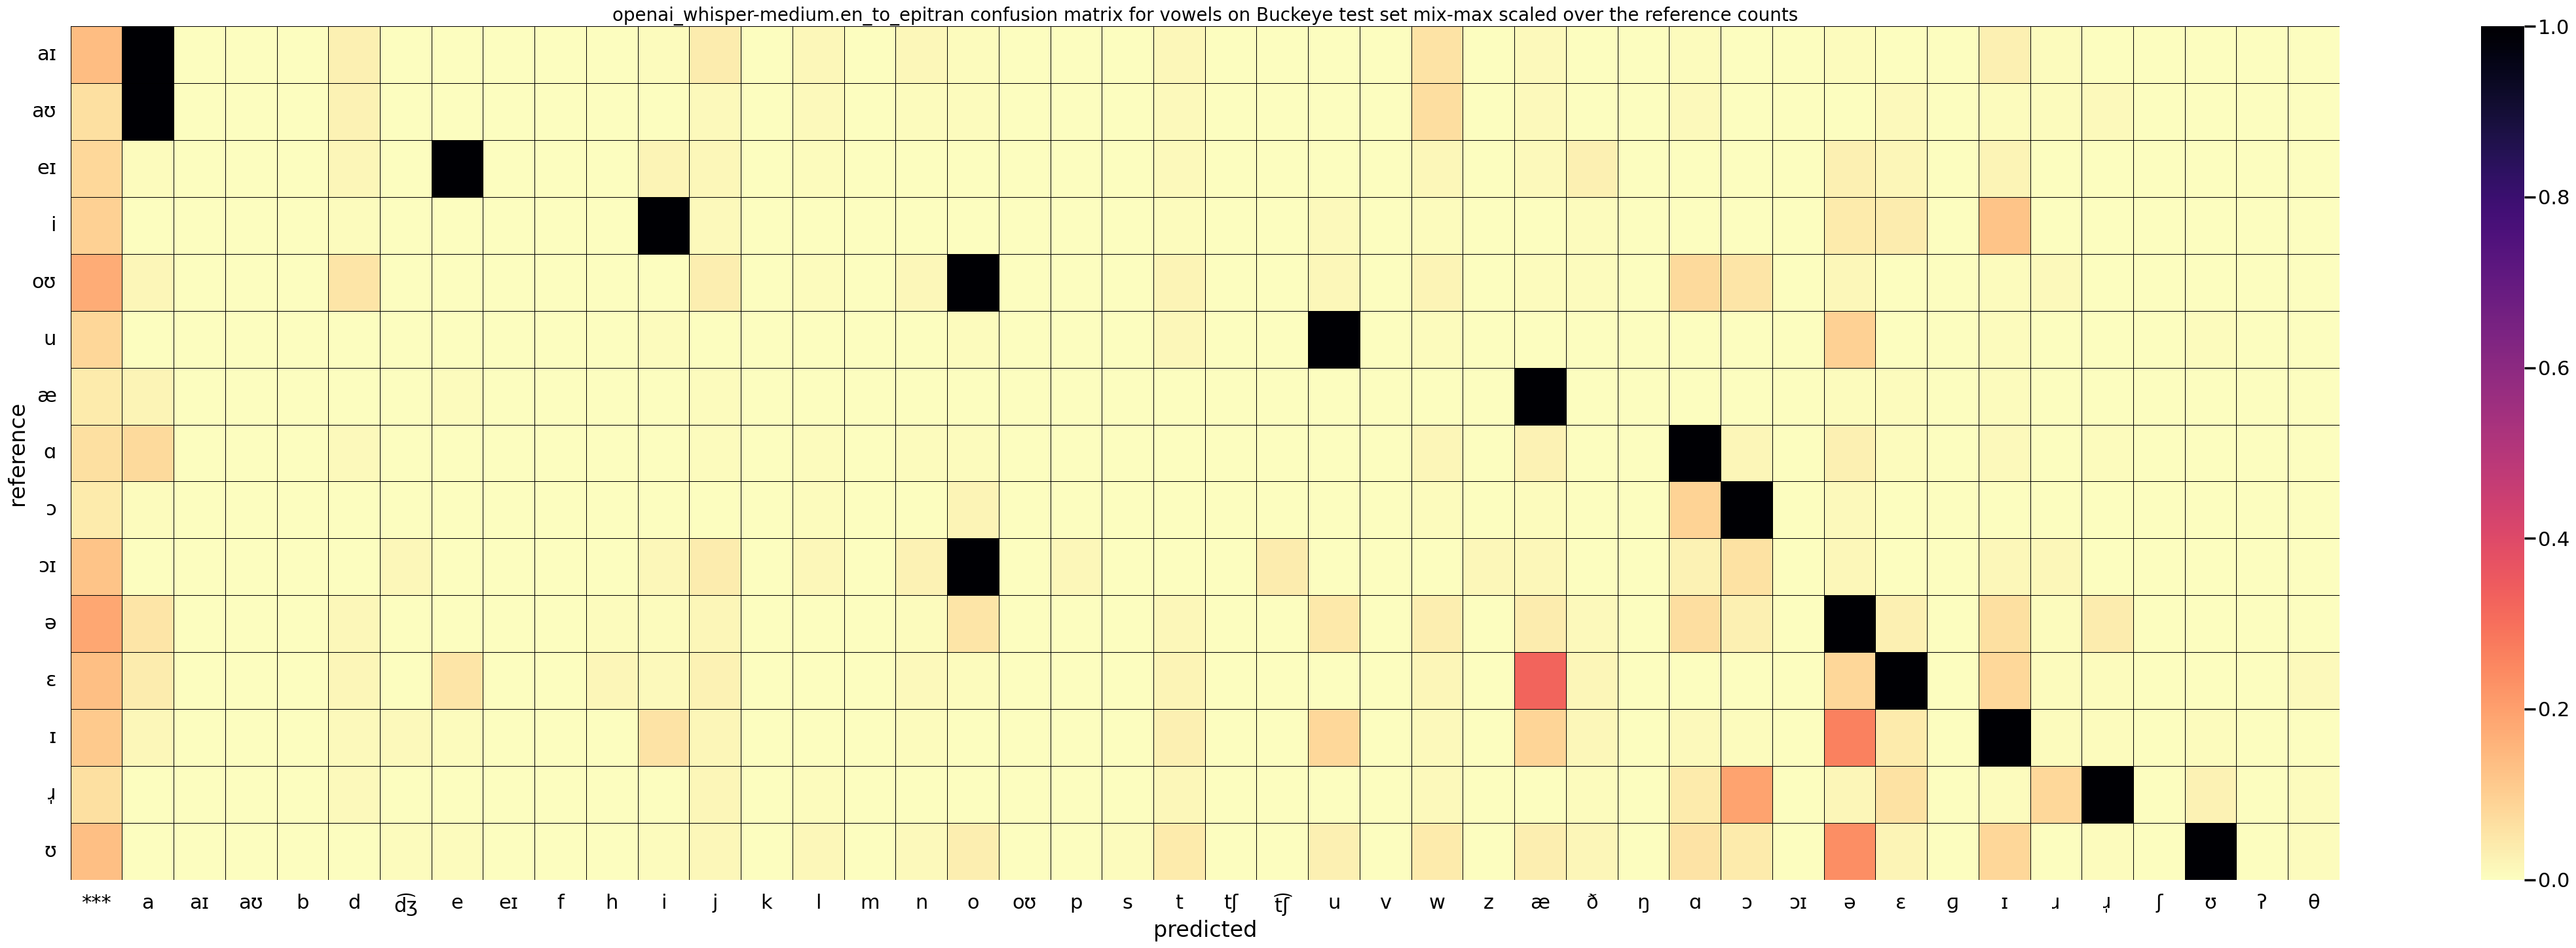

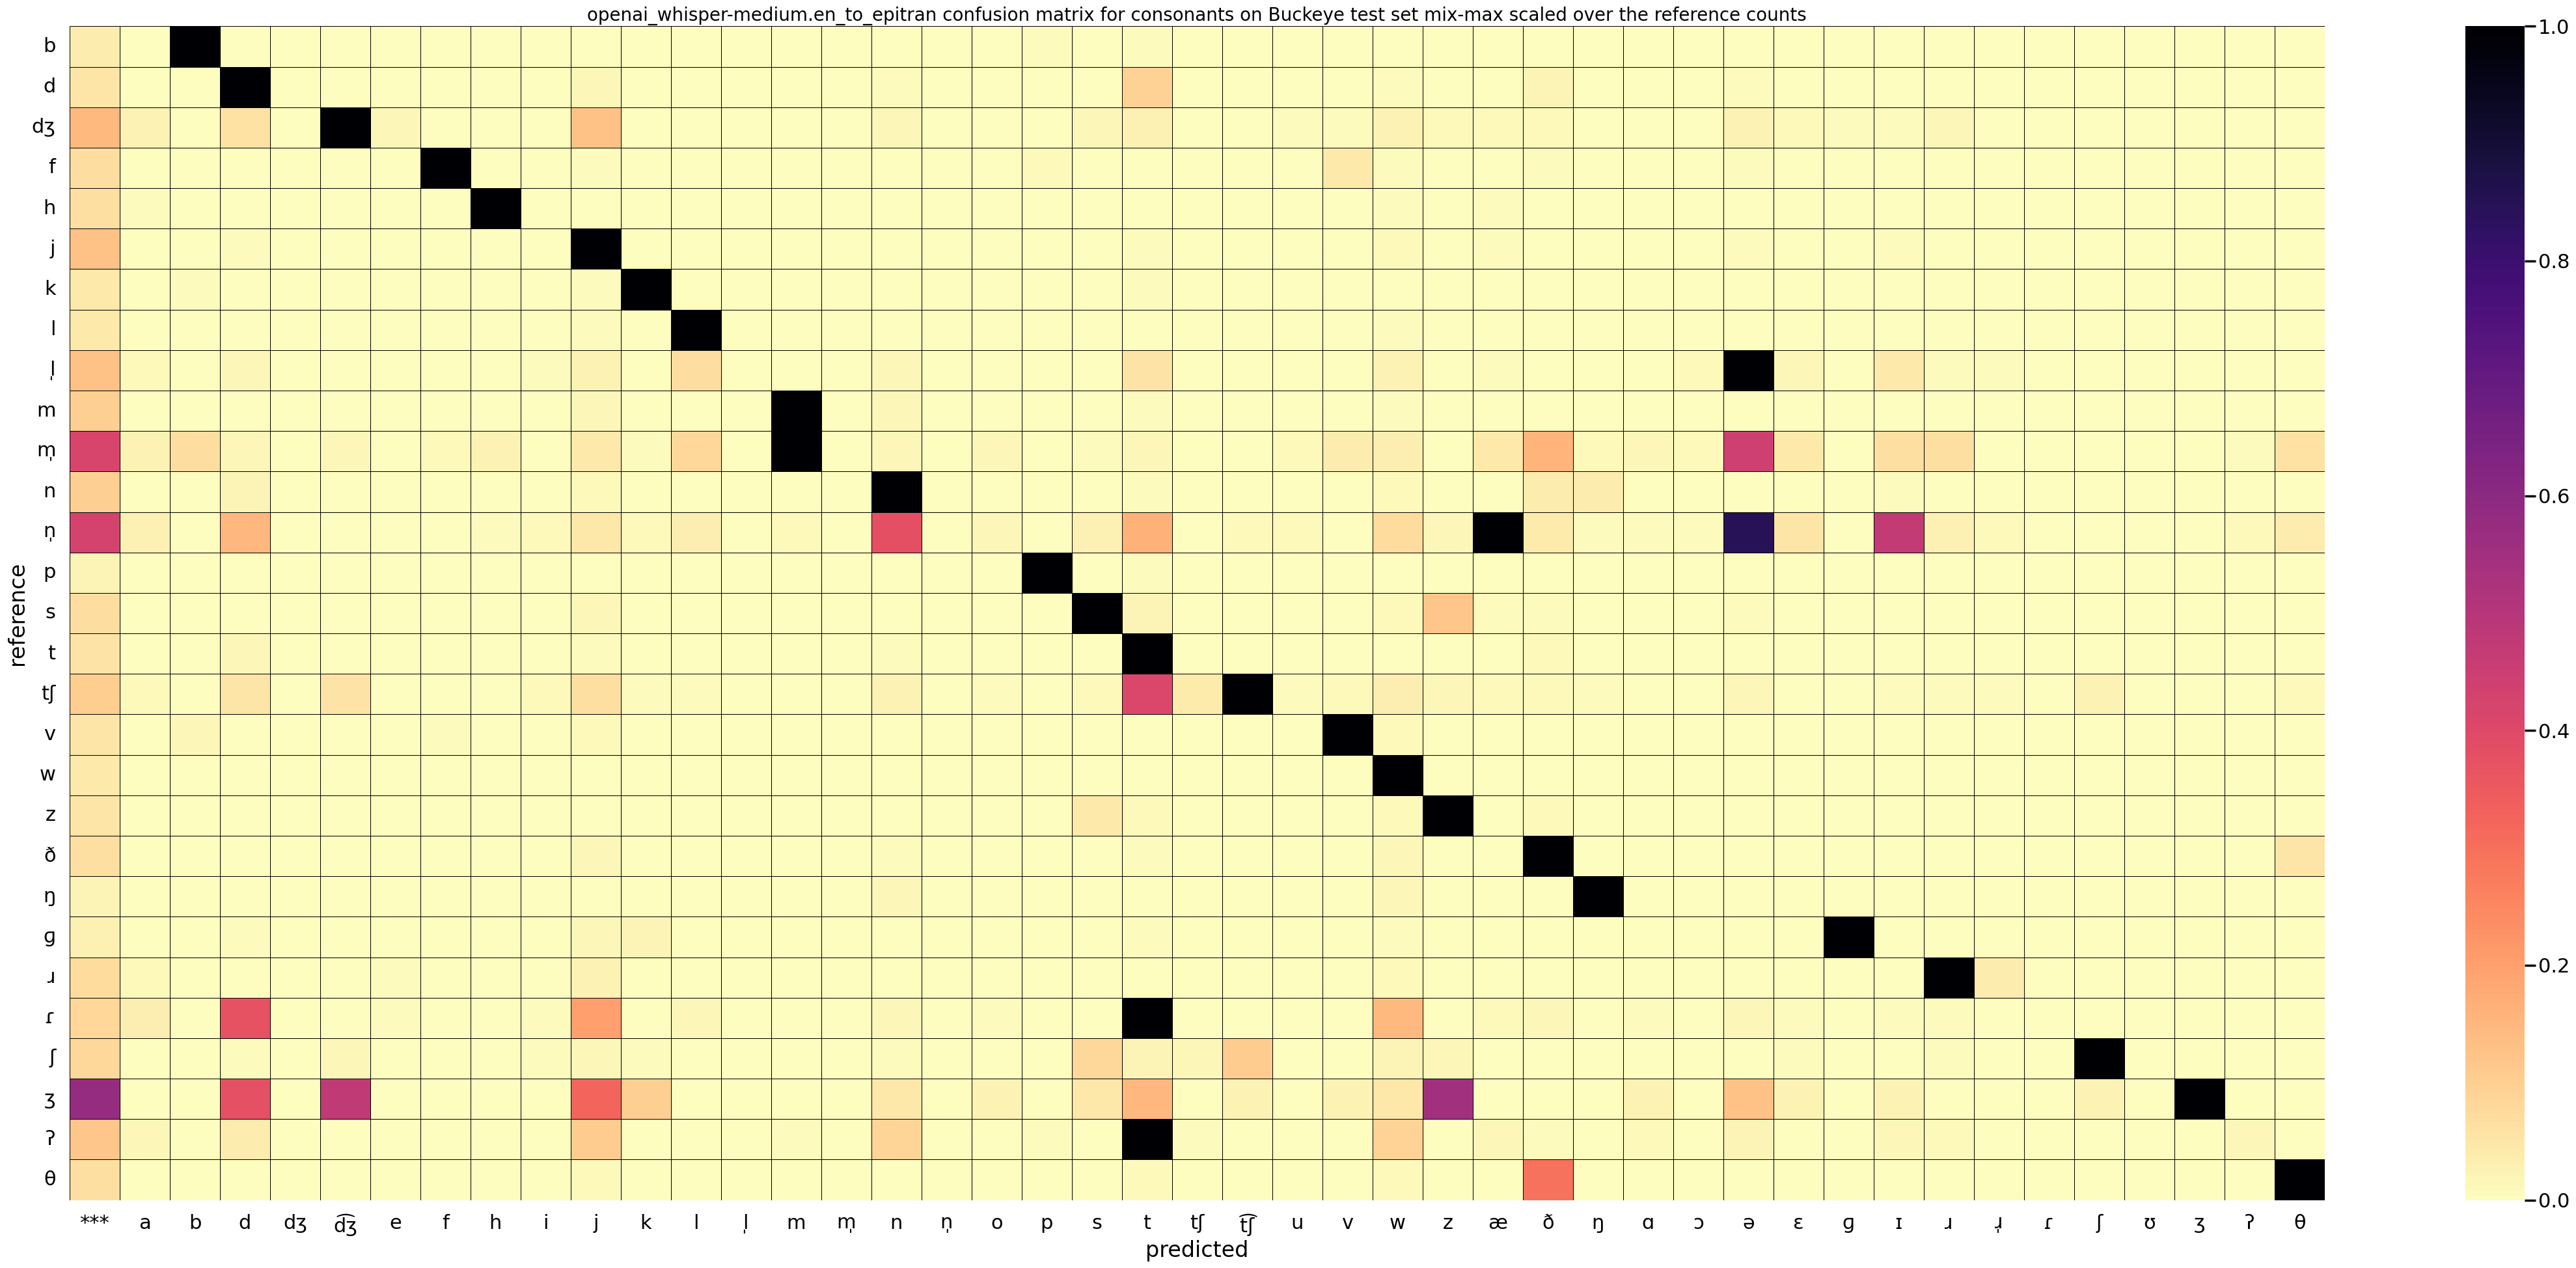

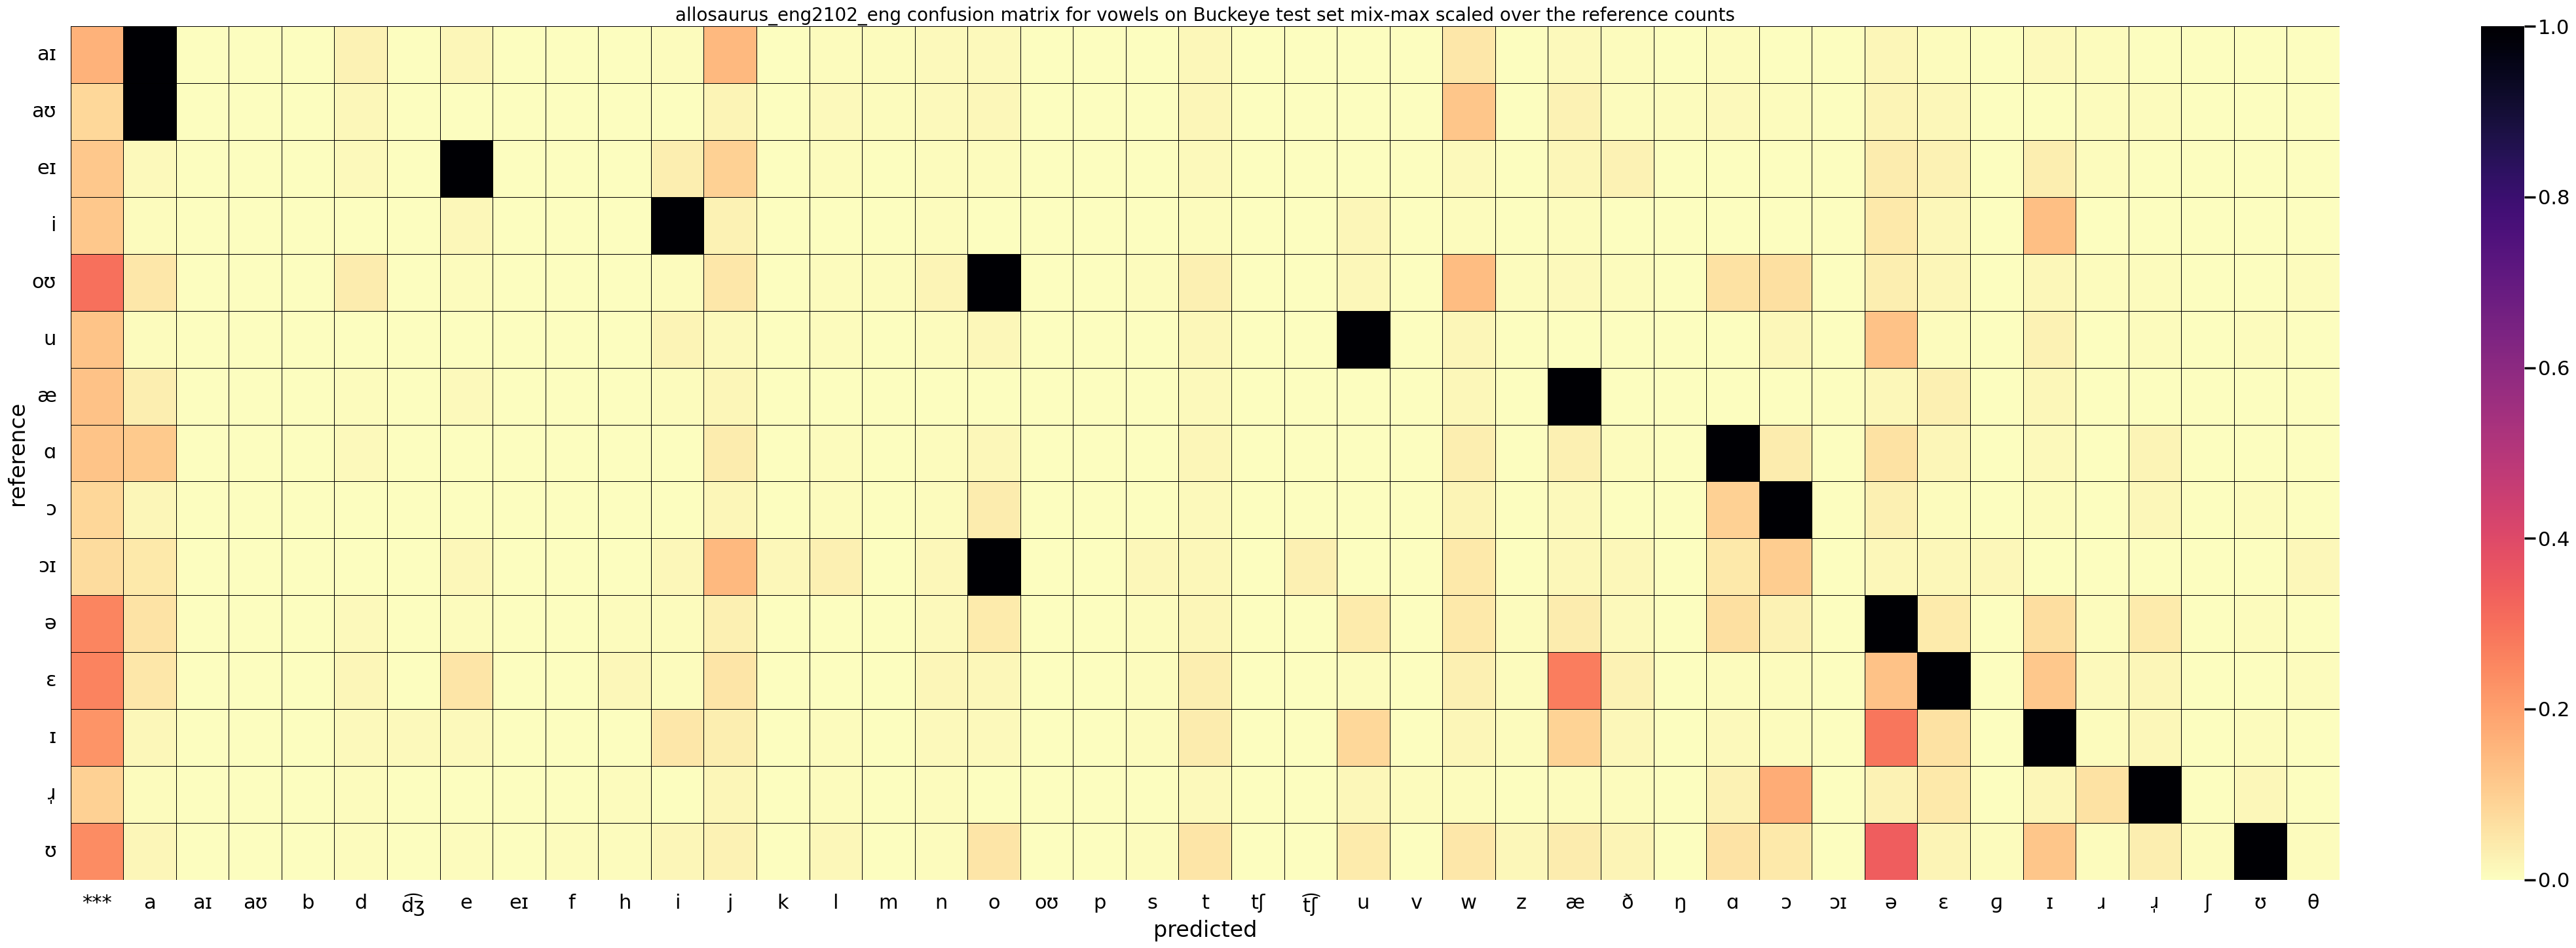

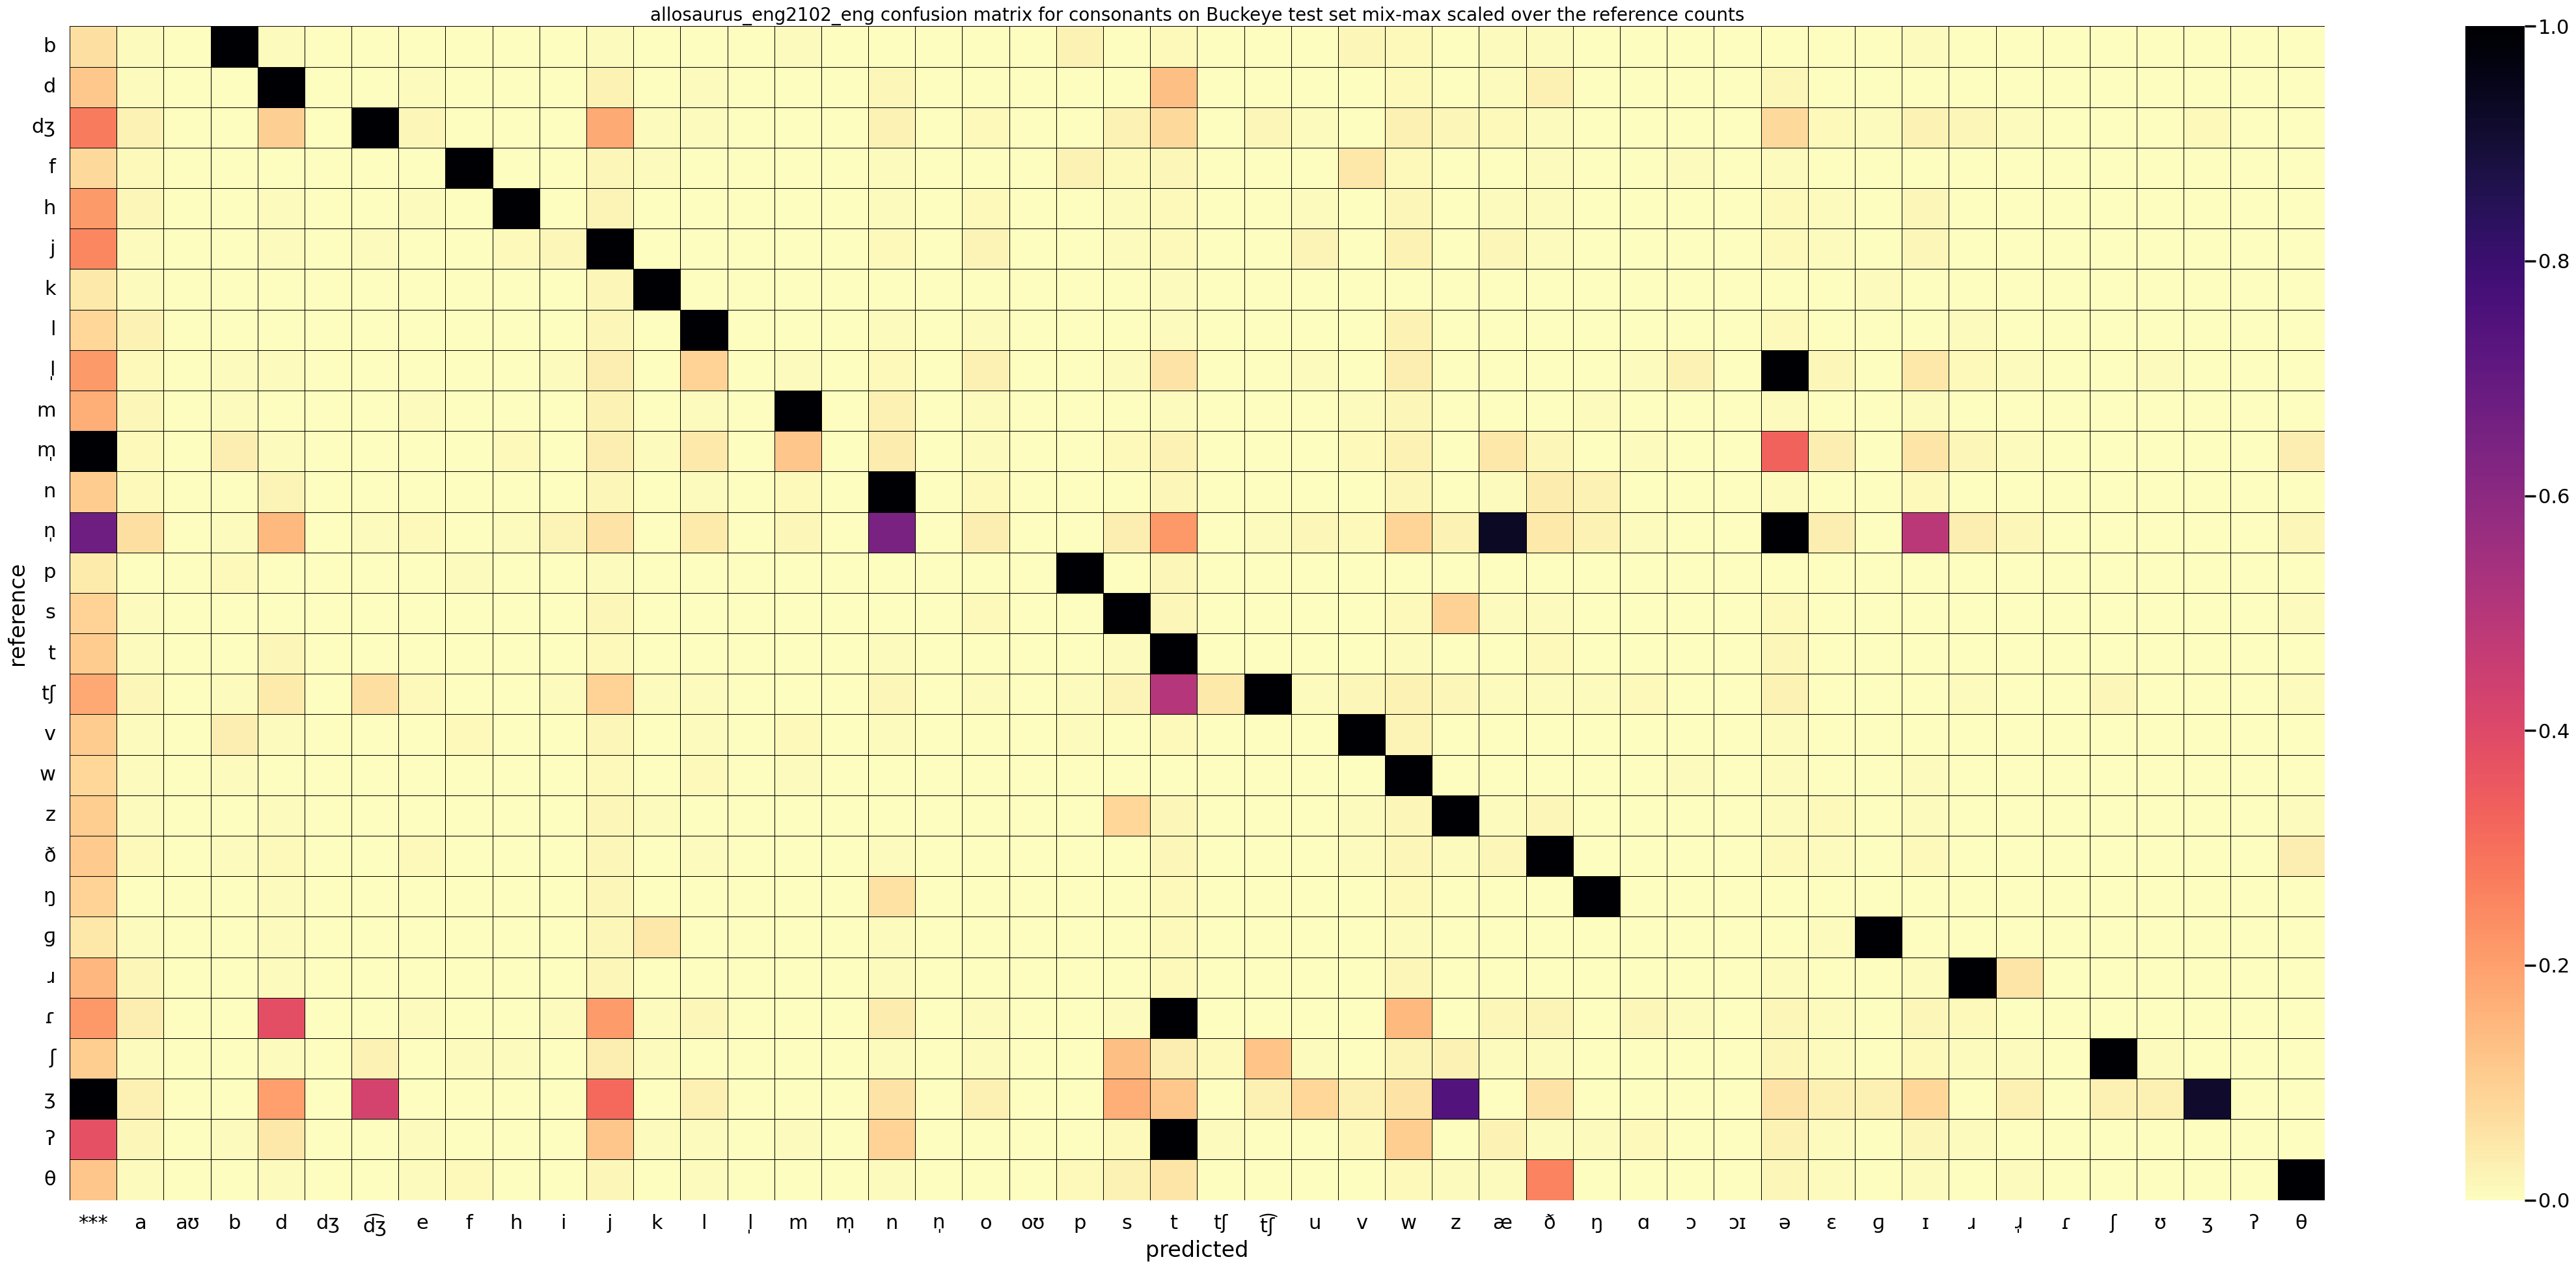

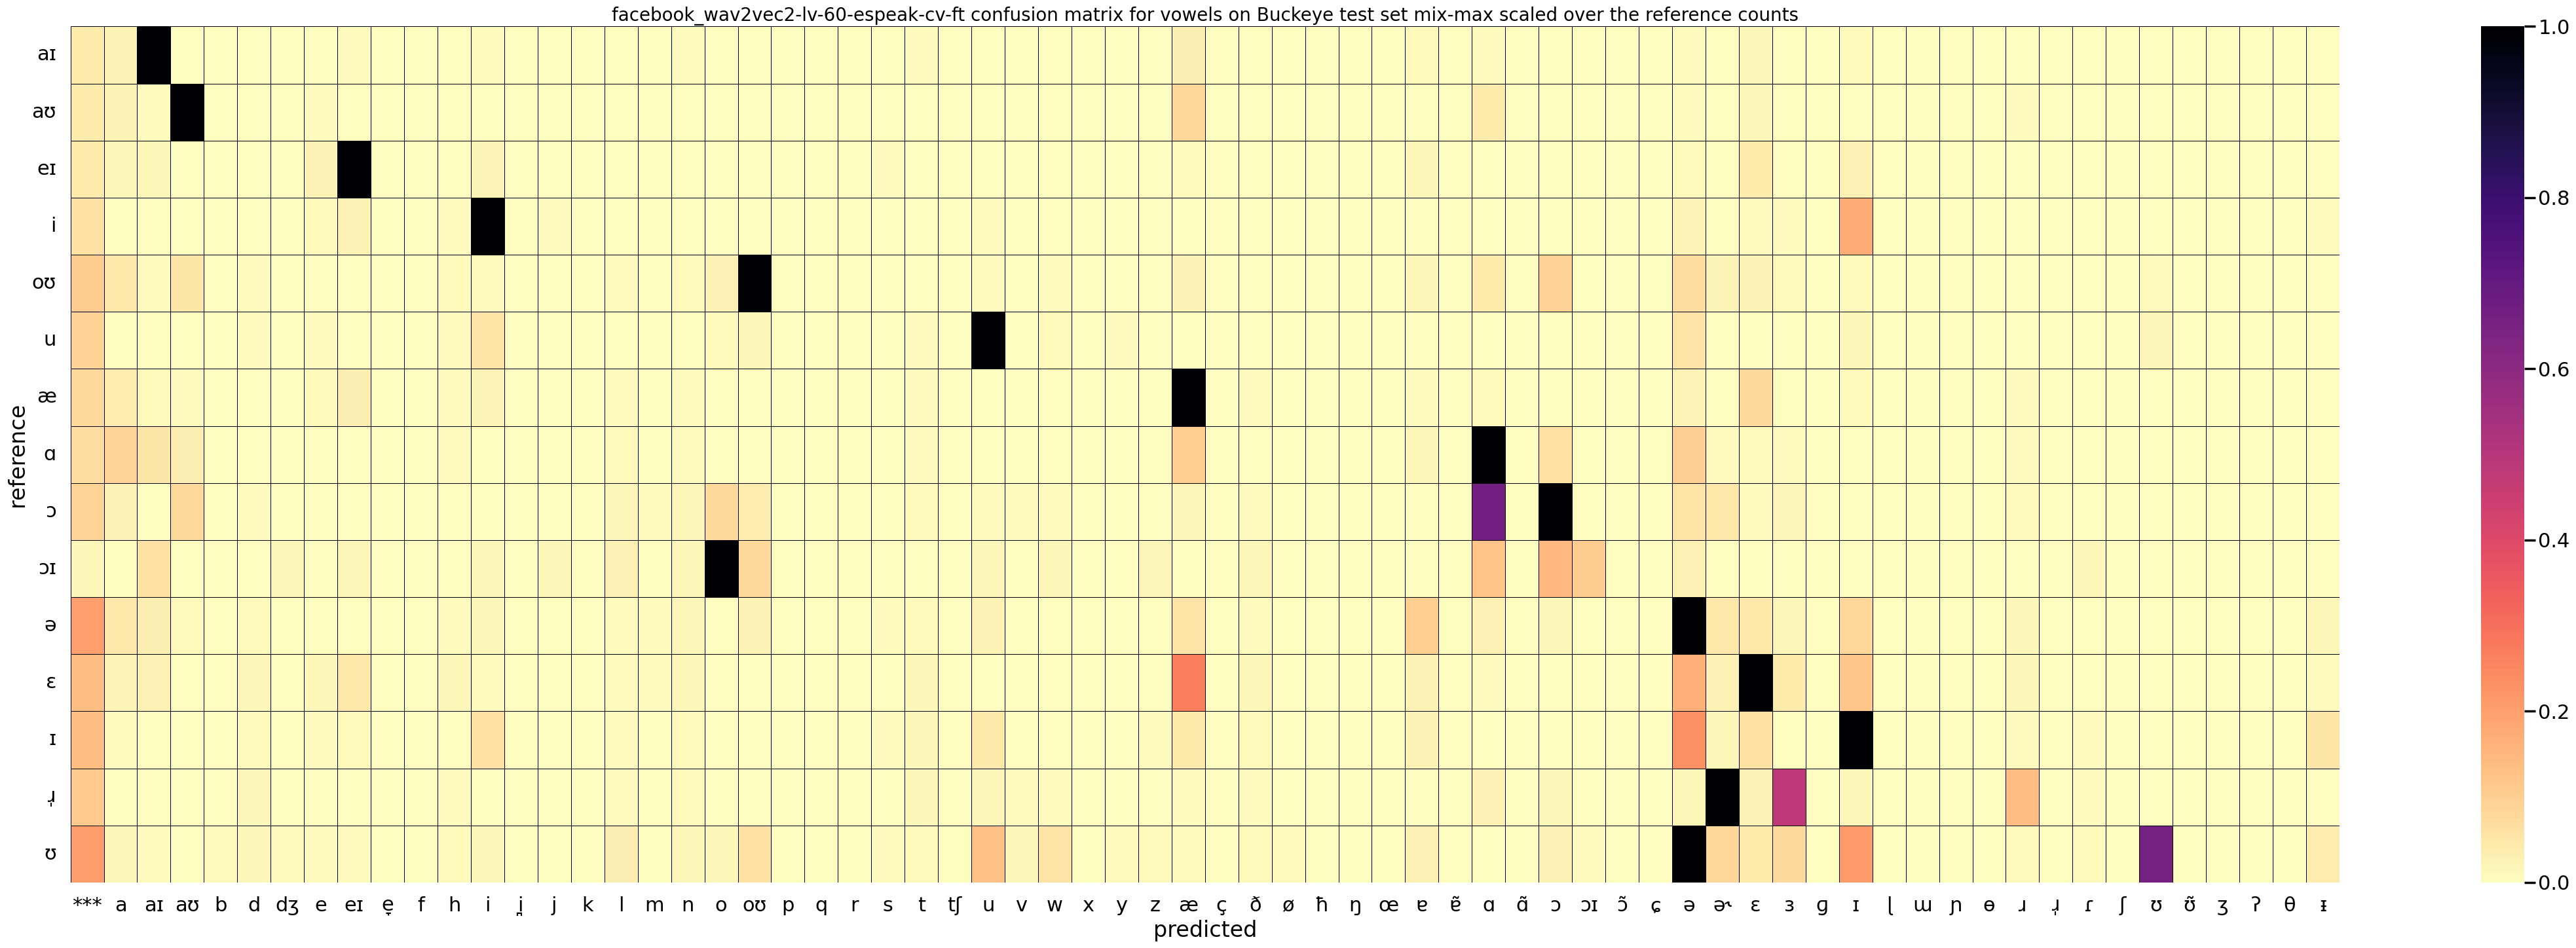

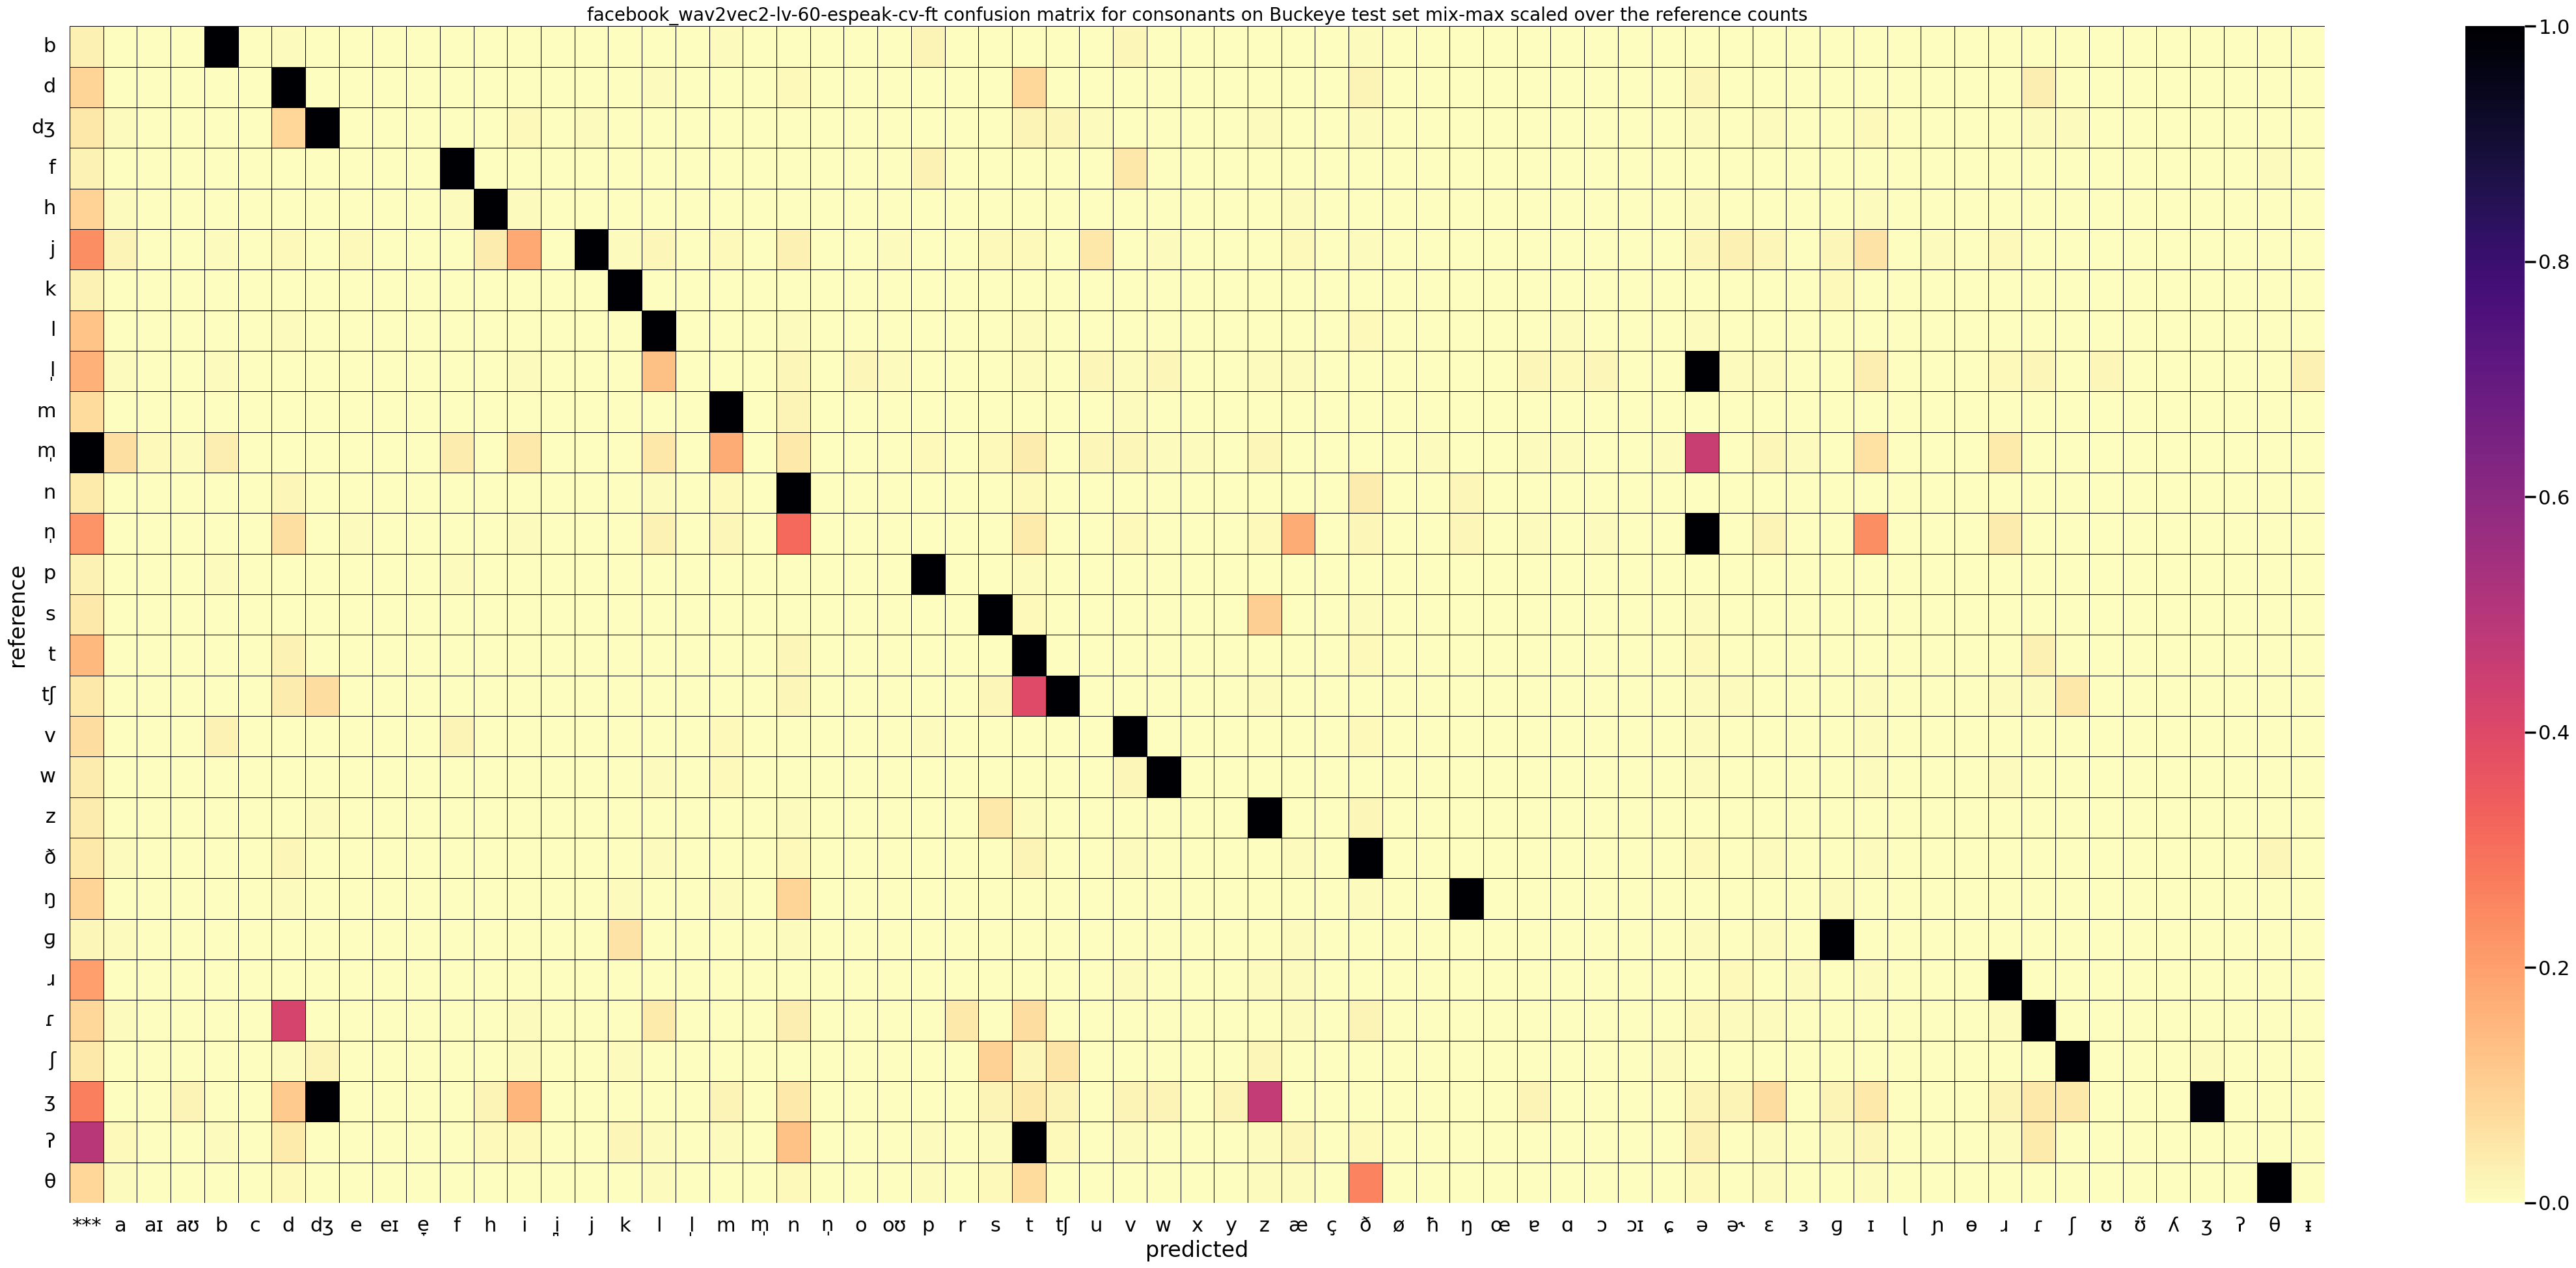

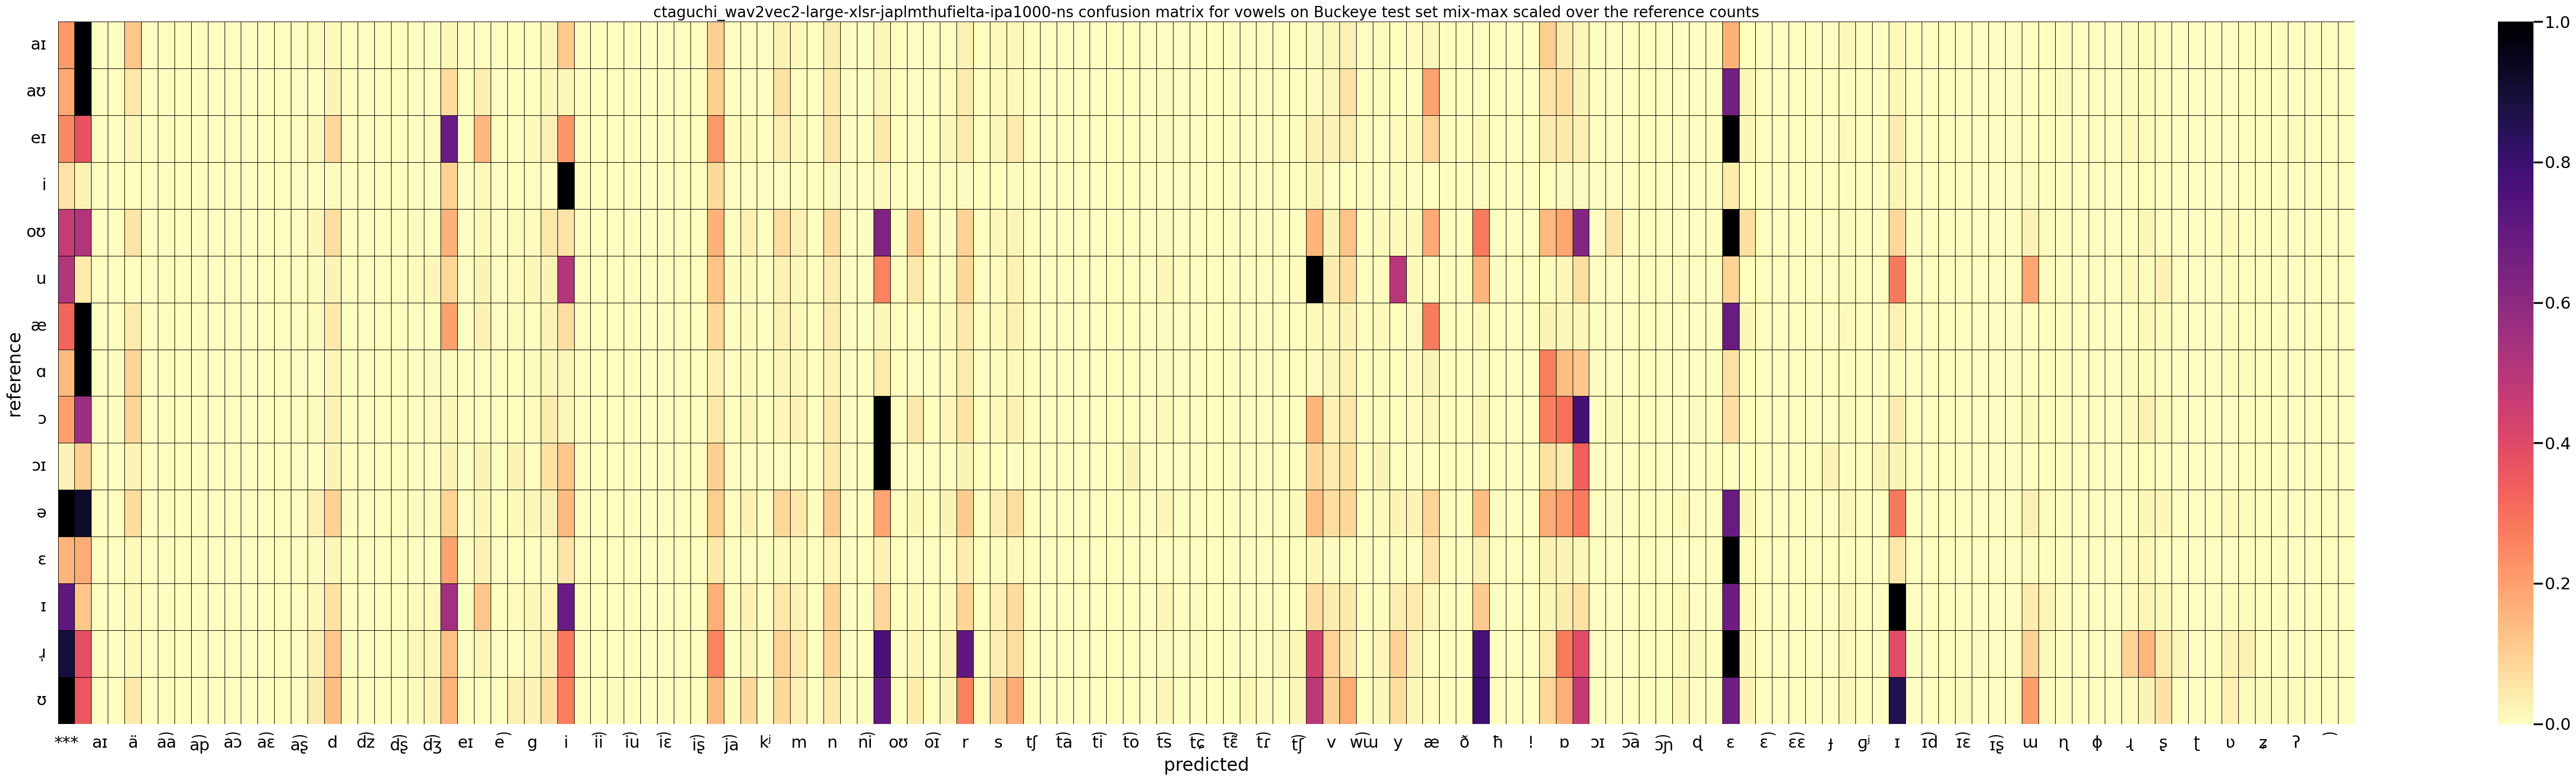

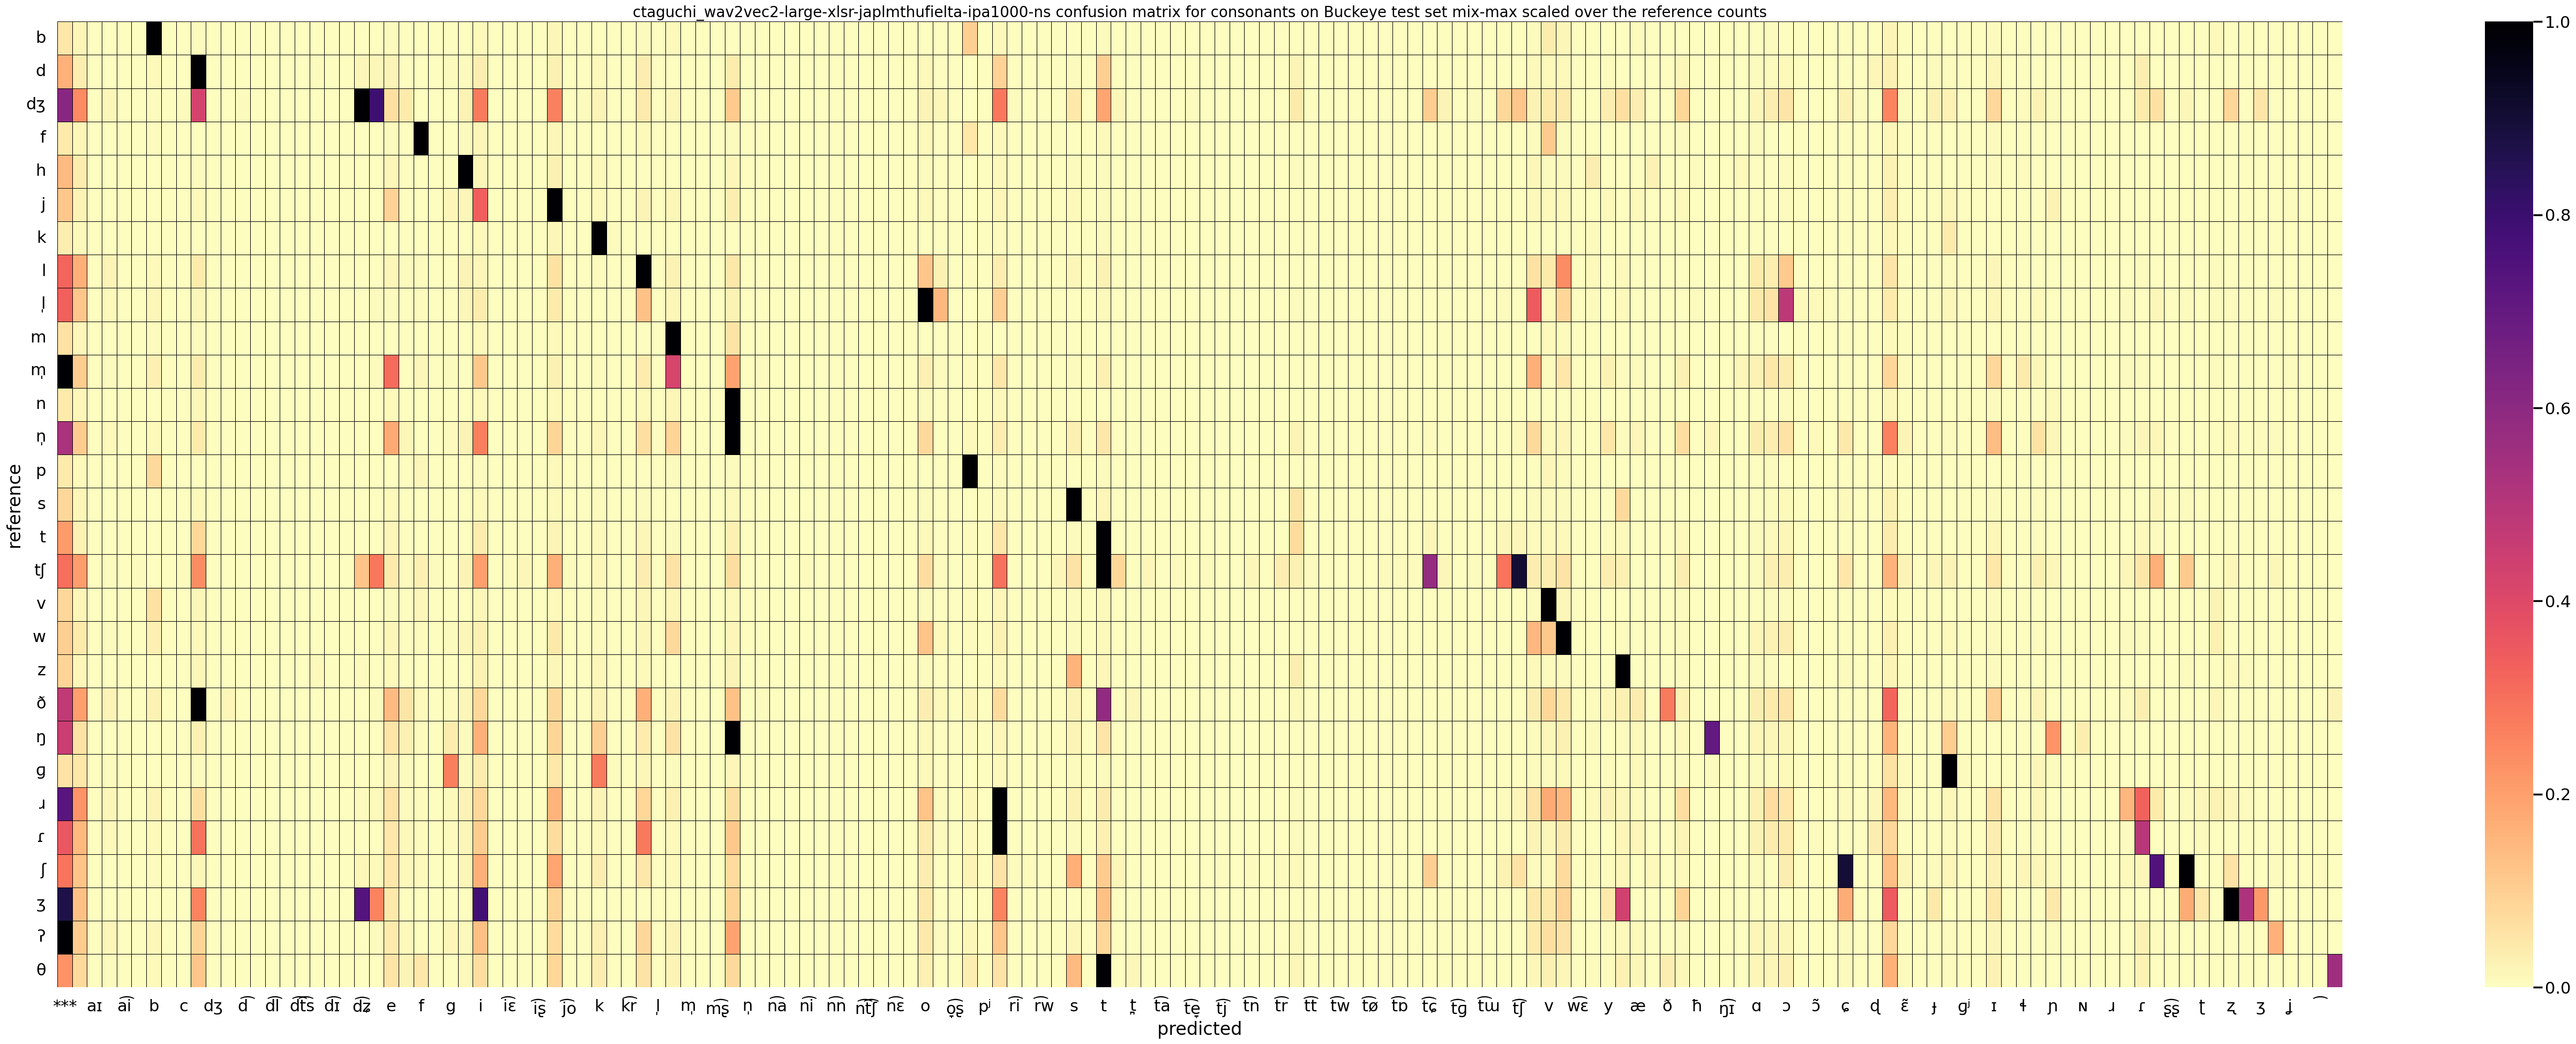

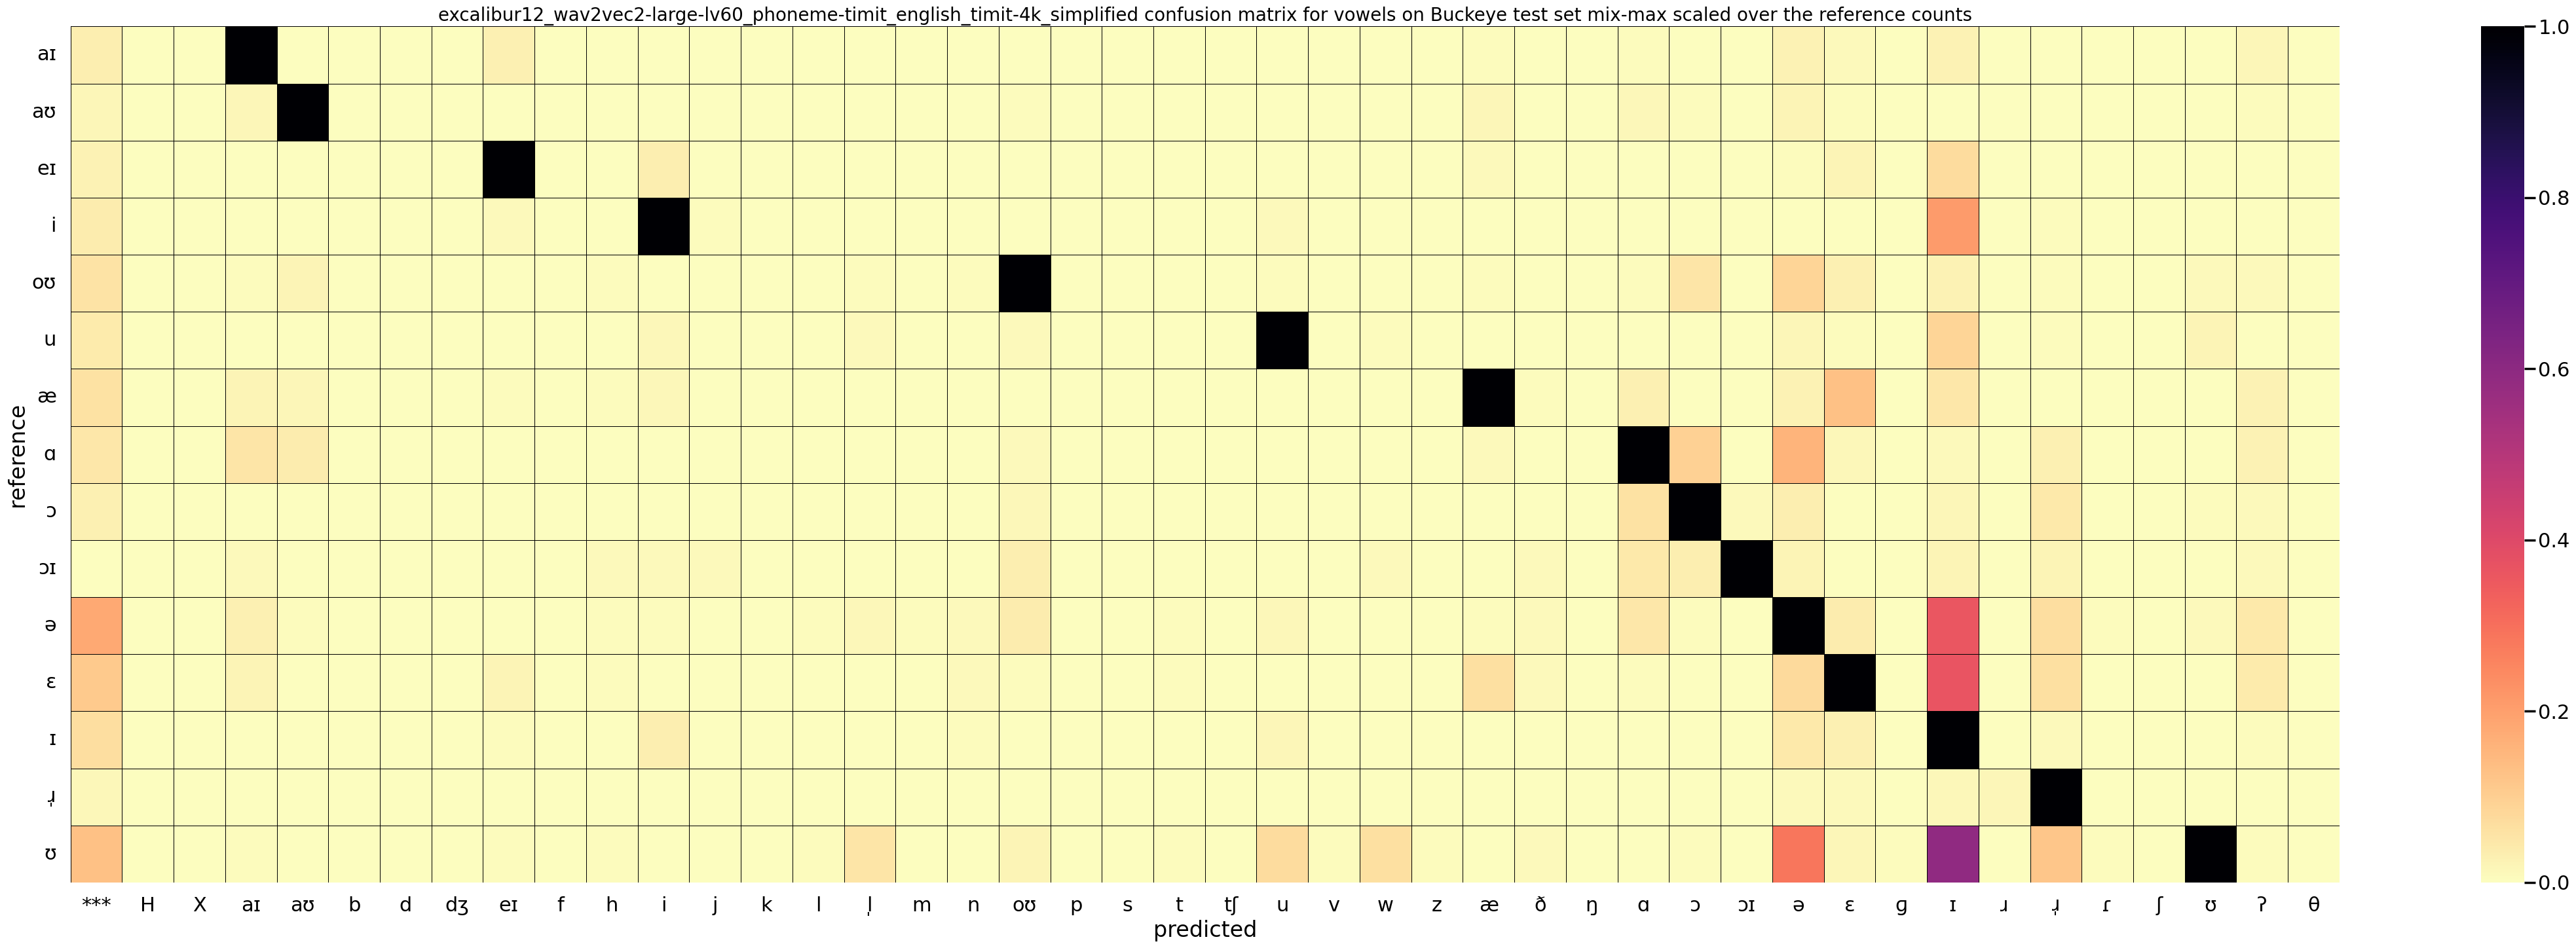

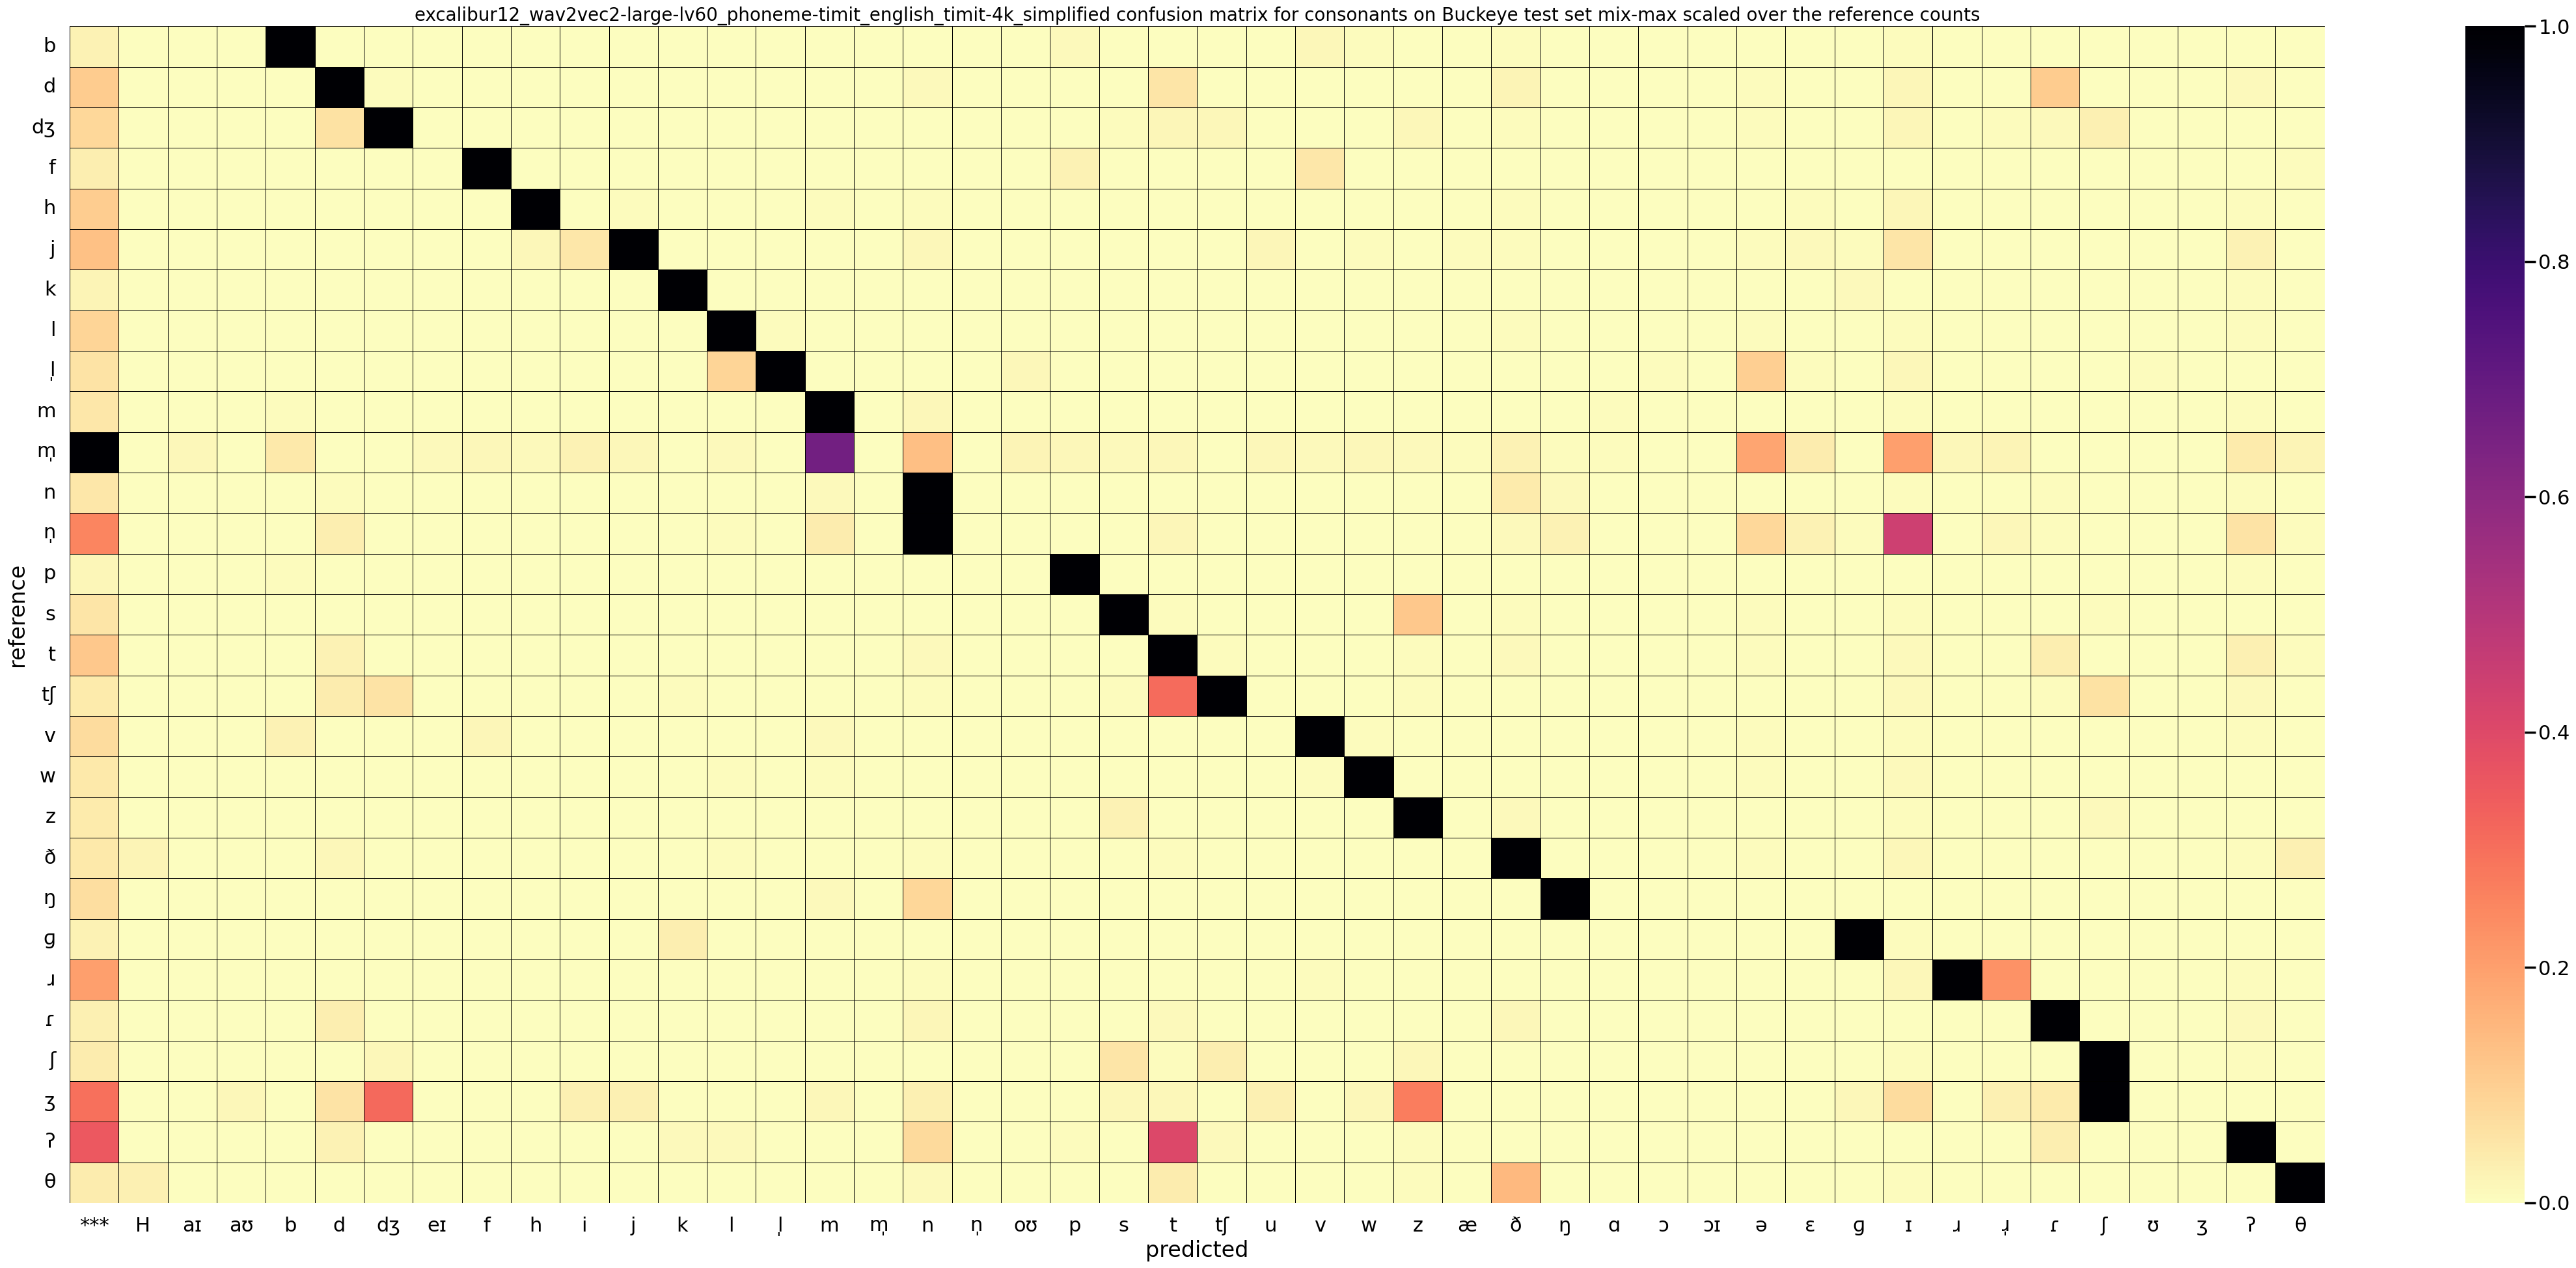

In [25]:
plt.clf()
desired_models_for_conf_matrix = [
    OUR_BEST_MODEL,
    "train_duration_20000_samples_3",
    "openai_whisper-medium.en_to_epitran",
    "allosaurus_eng2102_eng",
    "facebook_wav2vec2-lv-60-espeak-cv-ft",
    "ctaguchi_wav2vec2-large-xlsr-japlmthufielta-ipa1000-ns",
    "excalibur12_wav2vec2-large-lv60_phoneme-timit_english_timit-4k_simplified"
]
for mn in desired_models_for_conf_matrix:
    for (label, restriction) in [("vowels", BUCKEYE_VOWELS), ("consonants", BUCKEYE_CONSONANTS)]:
        height=15
        if label=="consonants":
            height=20
        if mn == "ctaguchi_wav2vec2-large-xlsr-japlmthufielta-ipa1000-ns":
            figsize = (55, height)
        else:
            figsize = (45, height)
        plot_token_confusion_matrix(
            conf_matrices[mn],
            f"{mn} confusion matrix for {label} on Buckeye test set mix-max scaled over the reference counts",
            reference_keys=restriction,
            figsize=figsize,
            #annot=True,
            #fmt='.0f',
            cmap="magma_r",
            #cmap="Grays",
            linewidth=0.5,
            linecolor="black",
            fontsize=20,
            is_normalize_rows=True
        )
        plt.tight_layout()
        plt.savefig(VIZ_OUTPUT_DIR / f"buckeye_test_{mn}_{label}_confusion_matrix.eps", format="eps")

# Vocabulary item counts in pivot table
Get vocabulary item counts for each model, put them in a pivot table and write to a CSV that helps you analyze differences between models offline. 

In [26]:
token_count_dfs = []
for model_name in desired_models_for_conf_matrix:
    matrix = conf_matrices[model_name]
    print("Model name:", model_name)
    token_count_df = matrix.groupby("predicted")["count"].sum().reset_index()
    token_count_df["model_name"] = model_name
    token_count_dfs.append(token_count_df)

full_token_count_df = pd.concat(token_count_dfs)
full_token_count_df = full_token_count_df[(full_token_count_df["count"] > 0) & (full_token_count_df["predicted"] != EPS)]
display(full_token_count_df.head())


Model name: full_dataset_train_5
Model name: train_duration_20000_samples_3
Model name: openai_whisper-medium.en_to_epitran
Model name: allosaurus_eng2102_eng
Model name: facebook_wav2vec2-lv-60-espeak-cv-ft
Model name: ctaguchi_wav2vec2-large-xlsr-japlmthufielta-ipa1000-ns
Model name: excalibur12_wav2vec2-large-lv60_phoneme-timit_english_timit-4k_simplified


,predicted,count,model_name
7,aɪ,4122,full_dataset_train_5
8,aʊ,903,full_dataset_train_5
9,b,3062,full_dataset_train_5
10,d,4051,full_dataset_train_5
11,dʒ,897,full_dataset_train_5


In [27]:
token_count_pivoted = full_token_count_df.pivot(columns="model_name", index="predicted", values="count")

In [28]:
token_count_pivoted.to_csv(TOKEN_ANALYSIS_OUTPUT)